# R+T+F model4

In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
import re 
from scipy import sparse
import time
import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_colwidth=300
pd.options.display.max_columns = 100

from sklearn.linear_model import Ridge

In [2]:
df = pd.read_csv('../input/rtf-de-tukauyatu/oversampled.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,text,y
0,0,49214,oh why dear johnny boy part one again do you want a fucking fight what the shit is your problem ooh he s personally attacking me grow up,2.08
1,1,91718,savant13 is a fat shite,3.58
2,2,83243,i am english i am i do not want to get blocked again fu k,0.80
3,3,112510,and why the fuck should i care g e t r i d o f a l l i d i d p l e a s e j a ck a s s,4.58
4,4,92430,yo dear sir james paul you a fruity ass nigga get a life man unless your happy with editing wikipedia as your profession feel bad for you its probably hard livin life without any friends,2.08


In [3]:
def text_cleaning(text):
    '''
    Cleans text into a basic form for NLP. Operations include the following:-
    1. Remove special charecters like &, #, etc
    2. Removes extra spaces
    3. Removes embedded URL links
    4. Removes HTML tags
    5. Removes emojis
    
    text - Text piece to be cleaned.
    '''
    template = re.compile(r'https?://\S+|www\.\S+') #Removes website links
    text = template.sub(r'', text)
    
    soup = BeautifulSoup(text, 'lxml') #Removes HTML tags
    only_text = soup.get_text()
    text = only_text
    
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    text = re.sub(r"[^a-zA-Z\d]", " ", text) #Remove special Charecters
    text = re.sub(' +', ' ', text) #Remove Extra Spaces
    text = text.strip() # remove spaces at the beginning and at the end of string

    return text

In [4]:
df = df.dropna(axis = 0)

In [5]:
vec = TfidfVectorizer(min_df= 3, max_df=0.5, analyzer = 'char_wb', ngram_range = (3,5), max_features = 46000)
vec.fit(df['text'])

TfidfVectorizer(analyzer='char_wb', max_df=0.5, max_features=46000, min_df=3,
                ngram_range=(3, 5))

In [6]:
from gensim.models import KeyedVectors, FastText

fmodel = FastText.load('../input/jigsaw-regression-based-data/FastText-jigsaw-256D/Jigsaw-Fasttext-Word-Embeddings-256D.bin')

In [7]:
from scipy.sparse import hstack

def splitter(text):
    tokens = []
    
    for word in text.split(' '):
        tokens.append(word)
    
    return tokens

def vectorizer(text):
    tokens = splitter(text)
    
    x1 = vec.transform([text]).toarray()
    x2 = np.mean(fmodel.wv[tokens], axis = 0).reshape(1, -1)
    x = np.concatenate([x1, x2], axis = -1).astype(np.float16)
    del x1
    del x2 
    
    return x   

In [8]:
X_list = []

for text in df.text:
    X_list.append(vectorizer(text))

In [9]:
EMB_DIM = len(vec.vocabulary_) + 256

In [10]:
X_np = np.array(X_list).reshape(-1, EMB_DIM)

In [11]:
from scipy import sparse

X = sparse.csr_matrix(X_np)
del X_np,X_list

In [12]:
%%time
model = Ridge(alpha=0.5)
model.fit(X, df['y'])

CPU times: user 5min 43s, sys: 2min 16s, total: 7min 59s
Wall time: 4min 13s


Ridge(alpha=0.5)

In [13]:
%%time
l_model = Ridge(alpha=1.)
l_model.fit(X, df['y'])

CPU times: user 4min 25s, sys: 1min 47s, total: 6min 12s
Wall time: 3min 17s


Ridge()

In [14]:
%%time
d_model = Ridge(alpha=1.5)
d_model.fit(X, df['y'])

CPU times: user 3min 35s, sys: 1min 27s, total: 5min 2s
Wall time: 2min 40s


Ridge(alpha=1.5)

In [15]:
%%time
s_model = Ridge(alpha=2.)
s_model.fit(X, df['y'])

CPU times: user 3min 13s, sys: 1min 17s, total: 4min 31s
Wall time: 2min 23s


Ridge(alpha=2.0)

In [16]:
# Validation data 

df_val = pd.read_csv("../input/jrstc-train-folds/validation_data_5_folds.csv")
for fold in range(5):
    exec_command1 = 'df_val_' + str(fold) + '=' + 'df_val[df_val.kfold ==' + str(fold) + '].reset_index(drop=True)'
    exec(exec_command1)

In [17]:
tqdm.pandas()

for fold in range(5):
    exec_command = 'df_val_' + str(fold) + '["less_toxic"]' '=' + 'df_val_' + str(fold) + '["less_toxic"].progress_apply(text_cleaning)'
    exec(exec_command)
    exec_command = 'df_val_' + str(fold) + '["more_toxic"]' '=' + 'df_val_' + str(fold) + '["more_toxic"].progress_apply(text_cleaning)'
    exec(exec_command)

  0%|          | 0/6022 [00:00<?, ?it/s]

  0%|          | 0/6022 [00:00<?, ?it/s]

  0%|          | 0/6022 [00:00<?, ?it/s]

  0%|          | 0/6022 [00:00<?, ?it/s]

  0%|          | 0/6022 [00:00<?, ?it/s]

  0%|          | 0/6022 [00:00<?, ?it/s]

  0%|          | 0/6021 [00:00<?, ?it/s]

  0%|          | 0/6021 [00:00<?, ?it/s]

  0%|          | 0/6021 [00:00<?, ?it/s]

  0%|          | 0/6021 [00:00<?, ?it/s]

In [18]:
X_less_toxic_temp_0 = []

for text in df_val_0.less_toxic:
    X_less_toxic_temp_0.append(vectorizer(text))

X_less_toxic_temp_0 = np.array(X_less_toxic_temp_0).reshape(-1, EMB_DIM)
X_less_toxic_0 = sparse.csr_matrix(X_less_toxic_temp_0)

del X_less_toxic_temp_0
    
X_more_toxic_temp_0 = []

for text in df_val_0.more_toxic:
    X_more_toxic_temp_0.append(vectorizer(text))
    
X_more_toxic_temp_0 = np.array(X_more_toxic_temp_0).reshape(-1, EMB_DIM)
X_more_toxic_0 = sparse.csr_matrix(X_more_toxic_temp_0)

del X_more_toxic_temp_0

In [19]:
X_less_toxic_temp_1 = []

for text in df_val_1.less_toxic:
    X_less_toxic_temp_1.append(vectorizer(text))

X_less_toxic_temp_1 = np.array(X_less_toxic_temp_1).reshape(-1, EMB_DIM)
X_less_toxic_1 = sparse.csr_matrix(X_less_toxic_temp_1)

del X_less_toxic_temp_1
    
X_more_toxic_temp_1 = []

for text in df_val_1.more_toxic:
    X_more_toxic_temp_1.append(vectorizer(text))
    
X_more_toxic_temp_1 = np.array(X_more_toxic_temp_1).reshape(-1, EMB_DIM)
X_more_toxic_1 = sparse.csr_matrix(X_more_toxic_temp_1)

del X_more_toxic_temp_1

In [20]:
X_less_toxic_temp_2 = []

for text in df_val_2.less_toxic:
    X_less_toxic_temp_2.append(vectorizer(text))

X_less_toxic_temp_2 = np.array(X_less_toxic_temp_2).reshape(-1, EMB_DIM)
X_less_toxic_2 = sparse.csr_matrix(X_less_toxic_temp_2)

del X_less_toxic_temp_2
    
X_more_toxic_temp_2 = []

for text in df_val_2.more_toxic:
    X_more_toxic_temp_2.append(vectorizer(text))
    
X_more_toxic_temp_2 = np.array(X_more_toxic_temp_2).reshape(-1, EMB_DIM)
X_more_toxic_2 = sparse.csr_matrix(X_more_toxic_temp_2)

del X_more_toxic_temp_2

In [21]:
X_less_toxic_temp_3 = []

for text in df_val_3.less_toxic:
    X_less_toxic_temp_3.append(vectorizer(text))

X_less_toxic_temp_3 = np.array(X_less_toxic_temp_3).reshape(-1, EMB_DIM)
X_less_toxic_3 = sparse.csr_matrix(X_less_toxic_temp_3)

del X_less_toxic_temp_3
    
X_more_toxic_temp_3 = []

for text in df_val_3.more_toxic:
    X_more_toxic_temp_3.append(vectorizer(text))
    
X_more_toxic_temp_3 = np.array(X_more_toxic_temp_3).reshape(-1, EMB_DIM)
X_more_toxic_3 = sparse.csr_matrix(X_more_toxic_temp_3)

del X_more_toxic_temp_3

In [22]:
X_less_toxic_temp_4 = []

for text in df_val_4.less_toxic:
    X_less_toxic_temp_4.append(vectorizer(text))

X_less_toxic_temp_4 = np.array(X_less_toxic_temp_4).reshape(-1, EMB_DIM)
X_less_toxic_4 = sparse.csr_matrix(X_less_toxic_temp_4)

del X_less_toxic_temp_4
    
X_more_toxic_temp_4 = []

for text in df_val_4.more_toxic:
    X_more_toxic_temp_4.append(vectorizer(text))
    
X_more_toxic_temp_4 = np.array(X_more_toxic_temp_4).reshape(-1, EMB_DIM)
X_more_toxic_4 = sparse.csr_matrix(X_more_toxic_temp_4)

del X_more_toxic_temp_4

In [23]:
p1_0 = model.predict(X_less_toxic_0)
p2_0 = model.predict(X_more_toxic_0)

p1_1 = model.predict(X_less_toxic_1)
p2_1 = model.predict(X_more_toxic_1)

p1_2 = model.predict(X_less_toxic_2)
p2_2 = model.predict(X_more_toxic_2)

p1_3 = model.predict(X_less_toxic_3)
p2_3 = model.predict(X_more_toxic_3)

p1_4 = model.predict(X_less_toxic_4)
p2_4 = model.predict(X_more_toxic_4)

In [24]:
# Validation Accuracy
print((p1_0 < p2_0).mean())
print((p1_1 < p2_1).mean())
print((p1_2 < p2_2).mean())
print((p1_3 < p2_3).mean())
print((p1_4 < p2_4).mean())

0.6433078711391564
0.6650614413816008
0.6609099966788442
0.665337983723634
0.6591928251121076


In [25]:
p3_0 = l_model.predict(X_less_toxic_0)
p4_0 = l_model.predict(X_more_toxic_0)

p3_1 = l_model.predict(X_less_toxic_1)
p4_1 = l_model.predict(X_more_toxic_1)

p3_2 = l_model.predict(X_less_toxic_2)
p4_2 = l_model.predict(X_more_toxic_2)

p3_3 = l_model.predict(X_less_toxic_3)
p4_3 = l_model.predict(X_more_toxic_3)

p3_4 = l_model.predict(X_less_toxic_4)
p4_4 = l_model.predict(X_more_toxic_4)

In [26]:
# Validation Accuracy
print((p3_0 < p4_0).mean())
print((p3_1 < p4_1).mean())
print((p3_2 < p4_2).mean())
print((p3_3 < p4_3).mean())
print((p3_4 < p4_4).mean())

0.647459315841913
0.6748588508801063
0.6663899036864829
0.6696562032884903
0.6645075568842385


In [27]:
p5_0 = d_model.predict(X_less_toxic_0)
p6_0 = d_model.predict(X_more_toxic_0)

p5_1 = d_model.predict(X_less_toxic_1)
p6_1 = d_model.predict(X_more_toxic_1)

p5_2 = d_model.predict(X_less_toxic_2)
p6_2 = d_model.predict(X_more_toxic_2)

p5_3 = d_model.predict(X_less_toxic_3)
p6_3 = d_model.predict(X_more_toxic_3)

p5_4 = d_model.predict(X_less_toxic_4)
p6_4 = d_model.predict(X_more_toxic_4)

In [28]:
# Validation Accuracy
print((p5_0 < p6_0).mean())
print((p5_1 < p6_1).mean())
print((p5_2 < p6_2).mean())
print((p5_3 < p6_3).mean())
print((p5_4 < p6_4).mean())

0.6494520092992362
0.6763533709730987
0.6728661574227831
0.6716492277030394
0.6703205447600067


In [29]:
p7_0 = s_model.predict(X_less_toxic_0)
p8_0 = s_model.predict(X_more_toxic_0)

p7_1 = s_model.predict(X_less_toxic_1)
p8_1 = s_model.predict(X_more_toxic_1)

p7_2 = s_model.predict(X_less_toxic_2)
p8_2 = s_model.predict(X_more_toxic_2)

p7_3 = s_model.predict(X_less_toxic_3)
p8_3 = s_model.predict(X_more_toxic_3)

p7_4 = s_model.predict(X_less_toxic_4)
p8_4 = s_model.predict(X_more_toxic_4)

In [30]:
print("Find right weight at fold 0 before scaling")

wts_acc_0 = []
for w1_0 in np.arange(0,1.05,0.05):
    for w2_0 in np.arange(0,1-w1_0,0.05):
        for w3_0 in np.arange(0,1-w1_0-w2_0,0.05):
            w4_0=1-w1_0-w2_0-w3_0
            p1_rtf_0 = w1_0*p1_0 + w2_0*p3_0 + w3_0*p5_0+w4_0*p7_0
            p2_rtf_0 = w1_0*p2_0 + w2_0*p4_0 + w3_0*p6_0+w4_0*p8_0
            wts_acc_0.append( (w1_0,w2_0,w3_0,w4_0, np.round((p1_rtf_0 < p2_rtf_0).mean() * 100,2))
                      )
w1_0,w2_0,w3_0,w4_0,acc_0 = sorted(wts_acc_0, key=lambda x:x[4], reverse=True)[0]
print(w1_0,w2_0,w3_0,w4_0,acc_0)

Find right weight at fold 0 before scaling
0.0 0.0 0.1 0.9 65.18


In [31]:
print("Find right weight at fold 1 before scaling")

wts_acc_1 = []
for w1_1 in np.arange(0,1.05,0.05):
    for w2_1 in np.arange(0,1-w1_1,0.05):
        for w3_1 in np.arange(0,1-w1_1-w2_1,0.05):
            w4_1=1-w1_1-w2_1-w3_1
            p1_rtf_1 = w1_1*p1_1 + w2_1*p3_1 + w3_1*p5_1+w4_1*p7_1
            p2_rtf_1 = w1_1*p2_1 + w2_1*p4_1 + w3_1*p6_1+w4_1*p8_1
            wts_acc_1.append( (w1_1,w2_1,w3_1,w4_1, np.round((p1_rtf_1 < p2_rtf_1).mean() * 100,2))
                      )
w1_1,w2_1,w3_1,w4_1,acc_1 = sorted(wts_acc_1, key=lambda x:x[4], reverse=True)[0]
print(w1_1,w2_1,w3_1,w4_1,acc_1)

Find right weight at fold 1 before scaling
0.0 0.25 0.65 0.09999999999999998 67.67


In [32]:
print("Find right weight at fold 2 before scaling")

wts_acc_2 = []
for w1_2 in np.arange(0,1.05,0.05):
    for w2_2 in np.arange(0,1-w1_2,0.05):
        for w3_2 in np.arange(0,1-w1_2-w2_2,0.05):
            w4_2=1-w1_2-w2_2-w3_2
            p1_rtf_2 = w1_2*p1_2 + w2_2*p3_2 + w3_2*p5_2+w4_2*p7_2
            p2_rtf_2 = w1_2*p2_2 + w2_2*p4_2 + w3_2*p6_2+w4_2*p8_2
            wts_acc_2.append( (w1_2,w2_2,w3_2,w4_2, np.round((p1_rtf_2 < p2_rtf_2).mean() * 100,2))
                      )
w1_2,w2_2,w3_2,w4_2,acc_2 = sorted(wts_acc_2, key=lambda x:x[4], reverse=True)[0]
print(w1_2,w2_2,w3_2,w4_2,acc_2)

Find right weight at fold 2 before scaling
0.1 0.05 0.8 0.04999999999999993 67.34


In [33]:
print("Find right weight at fold 3 before scaling")

wts_acc_3 = []
for w1_3 in np.arange(0,1.05,0.05):
    for w2_3 in np.arange(0,1-w1_3,0.05):
        for w3_3 in np.arange(0,1-w1_3-w2_3,0.05):
            w4_3=1-w1_3-w2_3-w3_3
            p1_rtf_3 = w1_3*p1_3 + w2_3*p3_3 + w3_3*p5_3+w4_3*p7_3
            p2_rtf_3 = w1_3*p2_3 + w2_3*p4_3 + w3_3*p6_3+w4_3*p8_3
            wts_acc_3.append( (w1_3,w2_3,w3_3,w4_3, np.round((p1_rtf_3< p2_rtf_3).mean() * 100,2))
                      )
w1_3,w2_3,w3_3,w4_3,acc_3 = sorted(wts_acc_3, key=lambda x:x[4], reverse=True)[0]
print(w1_3,w2_3,w3_3,w4_3,acc_3)

Find right weight at fold 3 before scaling
0.0 0.05 0.0 0.95 67.61


In [34]:
print("Find right weight at fold 4 before scaling")

wts_acc_4 = []
for w1_4 in np.arange(0,1.05,0.05):
    for w2_4 in np.arange(0,1-w1_4,0.05):
        for w3_4 in np.arange(0,1-w1_4-w2_4,0.05):
            w4_4=1-w1_4-w2_4-w3_4
            p1_rtf_4 = w1_4*p1_4 + w2_4*p3_4 + w3_4*p5_4+w4_4*p7_4
            p2_rtf_4 = w1_4*p2_4 + w2_4*p4_4 + w3_4*p6_4+w4_4*p8_4
            wts_acc_4.append( (w1_4,w2_4,w3_4,w4_4, np.round((p1_rtf_4 < p2_rtf_4).mean() * 100,2))
                      )
w1_4,w2_4,w3_4,w4_4,acc_4 = sorted(wts_acc_4, key=lambda x:x[4], reverse=True)[2]
#[1]だとばらけが少なかったから精度が同じの二個目を採用した。
print(w1_4,w2_4,w3_4,w4_4,acc_4)

Find right weight at fold 4 before scaling
0.0 0.05 0.9 0.04999999999999993 67.1


fold0~5のpは
p1_rtf_0
p2_rtf_0
とかに入っている

In [35]:
del p1_0,p3_0,p5_0,p7_0,p2_0,p4_0,p6_0,p8_0
del p1_1,p3_1,p5_1,p7_1,p2_1,p4_1,p6_1,p8_1
del p1_2,p3_2,p5_2,p7_2,p2_2,p4_2,p6_2,p8_2
del p1_3,p3_3,p5_3,p7_3,p2_3,p4_3,p6_3,p8_3
del p1_4,p3_4,p5_4,p7_4,p2_4,p4_4,p6_4,p8_4

# T+R+F submission data

In [36]:
best_rtf_w1=(w1_0+w1_1+w1_2+w1_3+w1_4)/5
best_rtf_w2=(w2_0+w2_1+w2_2+w2_3+w2_4)/5
best_rtf_w3=(w3_0+w3_1+w3_2+w3_3+w3_4)/5
best_rtf_w4=(w4_0+w4_1+w4_2+w4_3+w4_4)/5
print(best_rtf_w1,best_rtf_w2,best_rtf_w3,best_rtf_w4)
print(best_rtf_w1+best_rtf_w2+best_rtf_w3+best_rtf_w4)

0.02 0.07999999999999999 0.49000000000000005 0.41
1.0


In [37]:
df_rtf_sub = pd.read_csv("../input/jigsaw-toxic-severity-rating/comments_to_score.csv")

tqdm.pandas()
df_rtf_sub['text'] = df_rtf_sub['text'].progress_apply(text_cleaning)

X_sub_temp = []
for text in df_rtf_sub.text:
    X_sub_temp.append(vectorizer(text))
    
X_sub_temp = np.array(X_sub_temp).reshape(-1, EMB_DIM)
X_test = sparse.csr_matrix(X_sub_temp)

del X_sub_temp

p9 = model.predict(X_test)
p10 = l_model.predict(X_test)
p11 = d_model.predict(X_test)
p12 = s_model.predict(X_test)

df_rtf_sub['score'] = (p9*best_rtf_w1 + p10*best_rtf_w2 + p11*best_rtf_w3 + p12*best_rtf_w4)

  0%|          | 0/7537 [00:00<?, ?it/s]

# 3 data model

In [38]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
import re 
import scipy
from scipy import sparse
import gc 
from IPython.display import display, HTML
from pprint import pprint
import warnings
warnings.filterwarnings("ignore")


pd.options.display.max_colwidth=300

In [39]:
df = pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/train.csv")
print(df.shape)

for col in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    print(f'****** {col} *******')
    display(df.loc[df[col]==1,['comment_text',col]].sample(10))

(159571, 8)
****** toxic *******


,comment_text,toxic
146023,Hello you gajin cocksmooching piece of shit~ how is your me so horny mom and alcoholic dad doin? Chad Bryant 184.4.141.73,1
90847,""" """"Geraldo"""" aka Wikipedia Douchbag - you need to credit Kuma where he is pictured or take the photo of him down. Stop being such a dickhead. You are making it so much worst. He is the one seen in the cast photo whether you like it or not. Deal with it asshole!""",1
86742,"Final note \n\nYou are a melee mouthed internet addict who should get off his mutated Gluteus Maximus and aspire to something in life besides deleting edits on Wikipedia. And no, watching My Little Pony doesn't count.",1
81190,"help\nThis 'Historian' now thinks that 'Sanhedrin' is closer to Neturei Karta than to Kach. He is also seeing a fusion of Kach and Neturei Karta, since 'both oppose the state'. I tried to clarify it, giving some examples of the thought of NK and Kach (without naming either), and what is his conc...",1
6194,dont belives her he is a fking liar politely explain on this talk page fluck you liar all this stupis shit did is delete all the pages i creted cuking shit trash dont belive her,1
132362,"blocked \n\nis it true Jean Latore pimped your asshole out to some trannys on the streets of Brazil? lol, thats too funny",1
156880,Sory ToDST that was All My Roomates! They came in and Stormed my computer and Called You Gay! Which Your Not!,1
153542,U FAT NOOB!!\n\nI'm Samuel Gary Carter and I can't offend myself!!\n\nI didn't add either of those pages soo something must have hacked into mya ccount and done i tthere,1
10044,Please...do you have to waste your time to stupid messages like this one? I can switch to IP from another country in one minute. 177.47.116.74,1
150943,"""\n\nWell it seems that even providing a reference, some cunt has """"blocked me from editing"""". It gives further evidence to the dishonesty, unintelligence, and desire to suppress information which I expounded on """"Jimbo's"""" page.\nHere is the reference for """"pussy pelmet"""" I gave.\nhttp://www.in...",1


****** severe_toxic *******


,comment_text,severe_toxic
124389,"""\n\nhaha you are a dumb shit. what's so wrong about """"nazi"""" or """"hitler"""". some dumb american shit that makes nazi or hitler some how incomparable to any other shit? you know what, many people in the world think your dumb american imperialism, assault on iraq, are comparable to the atrocities ...",1
128037,Fuck Wikipedia!!! \n\nPeace (except to Wikipedia),1
43621,Suck my dick and swallow,1
15520,"You suck asshole,You suck asshole,You suck asshole,You suck asshole,You suck asshole,You suck asshole,You suck asshole,You suck asshole,You suck asshole,You suck asshole,You suck asYou suck asshole, you suck my dick. You think your so good at everything but you suck. I mean I was looking through...",1
157672,You're a fucking retard.149.254.186.158,1
37421,"GO FUCK YOUR SELF , WIKIADMINS",1
101953,"No, it was RE-ADD.. not read with two d's.. you STUPID FUCKING CUNT!!!!",1
92935,YOU FUCKING KIKE! DON'T EDIT THINGS YOU HAVE NO IDEA ABOUT! GIVE CREDIT WHERE IT'S DUE! YOU FUCKING KIKE! DON'T EDIT THINGS YOU HAVE NO IDEA ABOUT! GIVE CREDIT WHERE IT'S DUE! YOU FUCKING KIKE! DON'T EDIT THINGS YOU HAVE NO IDEA ABOUT! GIVE CREDIT WHERE IT'S DUE! YOU FUCKING KIKE! DON'T EDIT THI...,1
9629,fucking nob knight. Now fuck off and go vandalise something else fuck face,1
102032,"Those admins are fucking assholes, i just undid his removal of your text to his user page. check out this page to learn how to get around themn\n\nhttp://en.wikipedia.org/wiki/Wikipedia:VAN\n\nespeccially the sneaky edits part",1


****** obscene *******


,comment_text,obscene
156708,Abey Chutiyaay wikipedian. \n\nOye..\n\nLudayyy k baal you and Mr. Amartyabaag... what the fuck are you doing??\n\nLaand!!! I will kick off your ass If I found you. bloody... I'm collecting the pic's and posting it to wiki's and you harmi baal bengali bokka chooda deleting the pic's...\n\nSalley...,1
57767,"terrorist \n\nYOU FAILED AGAIN TO BLOCK ME WIKIPEDIANS!!\n\nHA HA!!\n\nFor some nice big juicy sweet cock,\nmy number is 248-678-9807\n\nGoodbye lovers.68.79.118.61",1
74343,"""\n\n [[User:Sennen goroshi Wow. A friendly advice to me from a wannabe-admistrator who is supposed to be """"no longer interested in this bulls**t"""" and enjoying his/her social life. Did you want so much to butt in my conversation with another editor? I don't understand your obsession with me. Do...",1
47459,Epoynme shows me there are worse users on here than you. That guy is a really racist and really dumb fuck.,1
146588,Get the fucking arse off this website.,1
42490,"YOu moron, do not accuse me to go and study. The fools and used like condom people with small or with no brains are YOU! That is also a reason why never Pashtuns can ever establish their fake claims (such as on Ghurids). Because you have no roots to anything. You are not related. Puta Khazana cl...",1
130726,"you are a prat, and my revenge will be sweet! hahahahahaahahahahahahahahahahahahahahaha.",1
81972,"why snarky, why here at all? Gravedancing too? Why did you thing thios is a request at all? Why not spend your time reading the whole ANI to learn something, and self-reflect? Too long eh. Happy kissing with your new friend Beetlefart. Take care, it might be a dick. -",1
113558,"lol kidding no offense\nmy dick, my dick",1
12329,"Interesting theory, detective. But who can say who anyone *is* really? What criterion of personal identity are we employing here? In any event , don't you think your time might be more profitably spent fixing the broken Heidegger page, in which I have already informed you and demonstrated, all ...",1


****** threat *******


,comment_text,threat
140018,"Oh not you again!!! And so? After the block has expired, Im gonna kick Gwerns ass again you admin wannabe!!! Im gonna rape you all!!!",1
20745,"You peice of irish scum \n\nHow dare you talk shit about my country? Fuck you, stupid shamrock bitch, I hope the next genocide we serve on you wipes your entire disgusting, repulsive race out. Fucking micks, you shouldn't even be alive after the first attempts, hopefully next time you wont be. D...",1
113946,"Napoleon Factor \n\nThis movie is like Napoleon Dynamite The audience loves it, even though there's actually nothing to it but clichés which literally get the shit beat out of them (as do most things in this movie). \n\nTo be fair, Napoleon Dynamite's bullettime scenes were only in how slow the ...",1
68264,"wtf? \n\nwtf is your problem? why are you being such an asswipe?\nThis is an educational institution, you have no right to block an eductational institution. I will promise you legal action if that continues. Against you and against your family and against anyone you may have that loves you. I d...",1
77923,Go fuck yourself \n\nEat shit and die. 68.0.119.139,1
138330,Oh of fuck you asshole die im going to kill you 96.244.254.20,1
82141,"Help! \n\nIf you become an admin, I will fuckin find ya then fuckin kill ya because you are a gross, fuckin homosexual who doesn't deserve the upgrade.",1
96240,I'm going to kill you all. \n\nI'm serious. You are all Retarder losers who deserve to die and I'm going to make sure that every single one of you suffers a horrible death.,1
40699,HAHAHAHAHAHAHAHA YOU CAN'T STOP ME FUCKING HOMO!!!!\nWHEN MY BAN EXPIRES TOMMORROW IM COMING AFTER YOUR GAY ASS ACCOUNT!!!,1
145157,@ Good! Just tell me how delete my account so I can get away from you and 's harassment and abuse. You two have made a powerful and unstoppable enemy once I find who your identities are and if you even come to Washington state. I will destroy you guys' life once I find your identities and you kn...,1


****** insult *******


,comment_text,insult
75330,"Hey, moron, why don't you read the entire edit requesting subject to see the sources I provided? And it doesn't hurt for wikipedia articles to be just a little bit accurate.",1
60126,"Hello, Brainwashed Vampire\n\nI will squash the CCP like the cucaracha it is!\n\nYou are a pathetic, brainless excuse for a human being....don't you realize the Beijing is the land of Mordor where the evil lies????????????????????",1
83067,"Ok, what is it \n\nWhy are you such a queer.. you have no power, so why the FUCK are you acting like you do. Grow up you fucking stupid shit head cock eating bastard.. seriously! Get a life, you're just a 17 yo piece of shit.",1
20683,"one final msg \n\nSeth, you have potential....to be a cocksucking faggot. get the fuck off wikipedia and find something productive to do, you little assclown",1
142884,FUC YOU DALE FUC YOU!,1
100788,"""\nThe question, actually, is not whether one would do that, it's whether one could do that. People have different moral compasses, and someone might have sex witha hooker, then kill her and take any money she has on her at the time (although doing so would enrage anyone she works for). -'''' ...",1
48079,"Your acts of vandalism on Iran-Iraq war article have been reverted. You are hereby warned to stop destroying the body of knowledge on this site. But alas, low lives like you are worthless and hopeless in extreme to understand what knowledge means. You are just a lackey of Saddam who has survived...",1
17813,Ill photo shop a dick in his illuminati mouth,1
144105,"You are a fucking cunt and a half. I hope your mother's vagina is raped with a chainsaw, you shit-eating pedophile.",1
60349,can suck my nine foot throbbing cock,1


****** identity_hate *******


,comment_text,identity_hate
46111,"I don't like the common negro \n\nThen again, who does?!? 86.178.203.222",1
128036,"What shit u talk to me, communist rat?",1
39305,"Can I Eye\nFUCK YOU YOU NEGRO SEE GROW 05:45, 14 Mar 2005 (UTC)",1
45053,Please do not add nonsense to Wikipeida unless it can be helped...faggots.,1
40585,hello \n\nyou are a nigger,1
91787,"""\n\n Anti-Semitism? I'm outta here! \n\nArchangel White Tiger:\n\nA few words, meow:\n\nOh, so I was banned for quoting the Torah! Excellent, the admins here are banning for """"personal attack on gays"""", when you recite The Words of The G-d, but no one was banned for saying, that holocaust victi...",1
30902,If you guys really discuss napoleon you need to get a fuckin life. it is so sad that you would rather discuss someone who has been dead for years then to look at porn.YOU GUYS R HOMOSEXUALS LIKE ANAL SEX TYPES,1
39108,"You're fucking nothing you little piece of shit faggot, fucking nothing \n\ncum drinking piece of shit.",1
122759,"Islam is the fastest growing religion in the world \n\nHave to love it, you dumb ugly racist!!",1
140961,yeah after few days some jews will say nasser al-kharafi is jew lol!,1


In [40]:
# Give more weight to severe toxic 
df['severe_toxic'] = df.severe_toxic * 2
df['y'] = (df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1) ).astype(int)
df['y'] = df['y']/df['y'].max()

df = df[['comment_text', 'y']].rename(columns={'comment_text': 'text'})
df.head()

,text,y
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0.0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0.0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0.0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no...",0.0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0.0


In [41]:
n_folds = 10

frac_1 = 0.3
frac_1_factor = 1.2

for fld in range(n_folds):
    print(f'Fold: {fld}')
    tmp_df = pd.concat([df[df.y>0].sample(frac=frac_1, random_state = 10*(fld+1)) , 
                        df[df.y==0].sample(n=int(len(df[df.y>0])*frac_1*frac_1_factor) , 
                                            random_state = 10*(fld+1))], axis=0).sample(frac=1, random_state = 10*(fld+1))

    tmp_df.to_csv(f'/kaggle/working/df_fld{fld}.csv', index=False)
    print(tmp_df.shape)
    print(tmp_df['y'].value_counts())

Fold: 0
(10709, 2)
0.000000    5841
0.142857    1903
0.428571    1208
0.285714    1032
0.714286     307
0.571429     294
0.857143     111
1.000000      13
Name: y, dtype: int64
Fold: 1
(10709, 2)
0.000000    5841
0.142857    1933
0.428571    1222
0.285714    1029
0.714286     318
0.571429     262
0.857143      96
1.000000       8
Name: y, dtype: int64
Fold: 2
(10709, 2)
0.000000    5841
0.142857    1870
0.428571    1233
0.285714    1074
0.714286     306
0.571429     278
0.857143      98
1.000000       9
Name: y, dtype: int64
Fold: 3
(10709, 2)
0.000000    5841
0.142857    1919
0.428571    1231
0.285714    1047
0.714286     298
0.571429     263
0.857143     104
1.000000       6
Name: y, dtype: int64
Fold: 4
(10709, 2)
0.000000    5841
0.142857    1874
0.428571    1261
0.285714    1011
0.714286     329
0.571429     292
0.857143      93
1.000000       8
Name: y, dtype: int64
Fold: 5
(10709, 2)
0.000000    5841
0.142857    1936
0.428571    1181
0.285714    1039
0.714286     330
0.571429   

In [42]:
import nltk
from nltk.corpus import stopwords
stop = stopwords.words('english')
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in text]

def clean(data, col):
    
    data[col] = data[col].str.replace(r"what's", "what is ")    
    data[col] = data[col].str.replace(r"\'ve", " have ")
    data[col] = data[col].str.replace(r"can't", "cannot ")
    data[col] = data[col].str.replace(r"n't", " not ")
    data[col] = data[col].str.replace(r"i'm", "i am ")
    data[col] = data[col].str.replace(r"\'re", " are ")
    data[col] = data[col].str.replace(r"\'d", " would ")
    data[col] = data[col].str.replace(r"\'ll", " will ")
    data[col] = data[col].str.replace(r"\'scuse", " excuse ")
    data[col] = data[col].str.replace(r"\'s", " ")

    # Clean some punctutations
    data[col] = data[col].str.replace('\n', ' \n ')
    data[col] = data[col].str.replace(r'([a-zA-Z]+)([/!?.])([a-zA-Z]+)',r'\1 \2 \3')
    # Replace repeating characters more than 3 times to length of 3
    data[col] = data[col].str.replace(r'([*!?\'])\1\1{2,}',r'\1\1\1')    
    # Add space around repeating characters
    data[col] = data[col].str.replace(r'([*!?\']+)',r' \1 ')    
    # patterns with repeating characters 
    data[col] = data[col].str.replace(r'([a-zA-Z])\1{2,}\b',r'\1\1')
    data[col] = data[col].str.replace(r'([a-zA-Z])\1\1{2,}\B',r'\1\1\1')
    data[col] = data[col].str.replace(r'[ ]{2,}',' ').str.strip()   
    data[col] = data[col].str.replace(r'[ ]{2,}',' ').str.strip()   
    data[col] = data[col].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    
    return data

In [43]:
# Test clean function
test_clean_df = pd.DataFrame({"text":
                              ["heyy\n\nkkdsfj",
                               "hi   how/are/you ???",
                               "hey?????",
                               "noooo!!!!!!!!!   comeone !! ",
                              "cooooooooool     brooooooooooo  coool brooo",
                              "naaaahhhhhhh"]})
display(test_clean_df)
clean(test_clean_df,'text')

,text
0,heyy\n\nkkdsfj
1,hi how/are/you ???
2,hey?????
3,noooo!!!!!!!!! comeone !!
4,cooooooooool brooooooooooo coool brooo
5,naaaahhhhhhh


,text
0,heyy kkdsfj
1,hi / are/you ???
2,hey ???
3,noo !!! comeone !!
4,coool broo coool broo
5,naaahh


In [44]:
df = clean(df,'text')

In [45]:
n_folds = 10

frac_1 = 0.3
frac_1_factor = 1.2

for fld in range(n_folds):
    tmp_df = pd.concat([df[df.y>0].sample(frac=frac_1, random_state = 10*(fld+1)) , 
                        df[df.y==0].sample(n=int(len(df[df.y>0])*frac_1*frac_1_factor) , 
                                            random_state = 10*(fld+1))], axis=0).sample(frac=1, random_state = 10*(fld+1))

    tmp_df.to_csv(f'/kaggle/working/df_clean_fld{fld}.csv', index=False)
    print(tmp_df.shape)
    print(tmp_df['y'].value_counts())

(10709, 2)
0.000000    5841
0.142857    1903
0.428571    1208
0.285714    1032
0.714286     307
0.571429     294
0.857143     111
1.000000      13
Name: y, dtype: int64
(10709, 2)
0.000000    5841
0.142857    1933
0.428571    1222
0.285714    1029
0.714286     318
0.571429     262
0.857143      96
1.000000       8
Name: y, dtype: int64
(10709, 2)
0.000000    5841
0.142857    1870
0.428571    1233
0.285714    1074
0.714286     306
0.571429     278
0.857143      98
1.000000       9
Name: y, dtype: int64
(10709, 2)
0.000000    5841
0.142857    1919
0.428571    1231
0.285714    1047
0.714286     298
0.571429     263
0.857143     104
1.000000       6
Name: y, dtype: int64
(10709, 2)
0.000000    5841
0.142857    1874
0.428571    1261
0.285714    1011
0.714286     329
0.571429     292
0.857143      93
1.000000       8
Name: y, dtype: int64
(10709, 2)
0.000000    5841
0.142857    1936
0.428571    1181
0.285714    1039
0.714286     330
0.571429     265
0.857143     109
1.000000       8
Name: y,

In [46]:
del df,tmp_df
gc.collect()

11963

(5838, 5)


<AxesSubplot:>

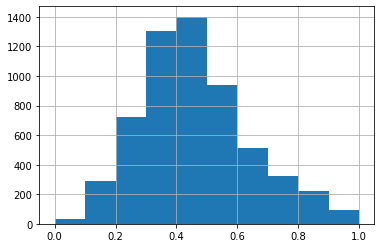

In [47]:
df_ = pd.read_csv("../input/d/rajkumarl/ruddit-jigsaw-dataset/Dataset/ruddit_with_text.csv")
print(df_.shape)

df_ = df_[['txt', 'offensiveness_score']].rename(columns={'txt': 'text',
                                                                'offensiveness_score':'y'})

df_['y'] = (df_['y'] - df_.y.min()) / (df_.y.max() - df_.y.min()) 
df_.y.hist()

In [48]:
n_folds = 10

frac_1 = 0.7

for fld in range(n_folds):
    print(f'Fold: {fld}')
    tmp_df = df_.sample(frac=frac_1, random_state = 10*(fld+1))
    tmp_df.to_csv(f'/kaggle/working/df2_fld{fld}.csv', index=False)
    print(tmp_df.shape)
    print(tmp_df['y'].value_counts())

Fold: 0
(4087, 2)
0.464668    125
0.475910    106
0.375268     94
0.442719     92
0.364561     89
           ... 
0.400964      1
0.889722      1
0.582976      1
0.404711      1
0.761242      1
Name: y, Length: 268, dtype: int64
Fold: 1
(4087, 2)
0.464668    107
0.475910    103
0.408994    102
0.386510     97
0.364561     88
           ... 
0.851713      1
0.859743      1
0.051927      1
0.666488      1
0.594754      1
Name: y, Length: 264, dtype: int64
Fold: 2
(4087, 2)
0.464668    118
0.475910    102
0.386510     94
0.442719     92
0.364561     89
           ... 
0.261777      1
0.238223      1
0.123126      1
0.694861      1
0.309422      1
Name: y, Length: 265, dtype: int64
Fold: 3
(4087, 2)
0.464668    116
0.475910    106
0.386510     93
0.408994     92
0.364561     90
           ... 
0.238223      1
0.561028      1
0.404711      1
0.806210      1
0.184154      1
Name: y, Length: 263, dtype: int64
Fold: 4
(4087, 2)
0.464668    122
0.475910    114
0.386510    100
0.442719     91
0.

In [49]:
del tmp_df, df_; 
gc.collect()

42

In [50]:
# Validation data 

df_val = pd.read_csv("../input/jrstc-train-folds/validation_data_5_folds.csv")
for fold in range(5):
    exec_command1 = 'df_val_' + str(fold) + '=' + 'df_val[df_val.kfold ==' + str(fold) + '].reset_index(drop=True)'
    exec(exec_command1)

In [51]:
# NOT USED 
class LengthTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return sparse.csr_matrix([[(len(x)-360)/550] for x in X])
    def get_feature_names(self):
        return ["lngth"]

class LengthUpperTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return sparse.csr_matrix([[sum([1 for y in x if y.isupper()])/len(x)] for x in X])
    def get_feature_names(self):
        return ["lngth_uppercase"]

In [52]:
for fold in range(5):
    exec_command1 = 'df_val_' + str(fold) + '["upper_1"]'+ '=' + 'np.array(LengthUpperTransformer().transform(df_val_' + str(fold) + '["less_toxic"]).todense()).reshape(-1,1)'
    exec(exec_command1)
    
    exec_command2 = 'df_val_' + str(fold) + '["upper_2"]'+ '=' + 'np.array(LengthUpperTransformer().transform(df_val_' + str(fold) + '["more_toxic"]).todense()).reshape(-1,1)'
    exec(exec_command2)

In [53]:
df_3data_sub = pd.read_csv("../input/jigsaw-toxic-severity-rating/comments_to_score.csv")

In [54]:
val_preds_arr1_0 = np.zeros((df_val_0.shape[0], n_folds))
val_preds_arr2_0 = np.zeros((df_val_0.shape[0], n_folds))
val_preds_arr1_1 = np.zeros((df_val_1.shape[0], n_folds))
val_preds_arr2_1 = np.zeros((df_val_1.shape[0], n_folds))
val_preds_arr1_2 = np.zeros((df_val_2.shape[0], n_folds))
val_preds_arr2_2 = np.zeros((df_val_2.shape[0], n_folds))
val_preds_arr1_3 = np.zeros((df_val_3.shape[0], n_folds))
val_preds_arr2_3 = np.zeros((df_val_3.shape[0], n_folds))
val_preds_arr1_4 = np.zeros((df_val_4.shape[0], n_folds))
val_preds_arr2_4 = np.zeros((df_val_4.shape[0], n_folds))
test_preds_arr = np.zeros((df_3data_sub.shape[0], n_folds))

for fld in range(n_folds):
    print("\n\n")
    print(f' ****************************** FOLD: {fld} ******************************')
    df = pd.read_csv(f'/kaggle/working/df_fld{fld}.csv')
    print(df.shape)

    features = FeatureUnion([
        #('vect1', LengthTransformer()),
        #('vect2', LengthUpperTransformer()),
        ("vect3", TfidfVectorizer(min_df= 3, max_df=0.5, analyzer = 'char_wb', ngram_range = (3,5))),
        #("vect4", TfidfVectorizer(min_df= 5, max_df=0.5, analyzer = 'word', token_pattern=r'(?u)\b\w{8,}\b')),

    ])
    pipeline = Pipeline(
        [
            ("features", features),
            #("clf", RandomForestRegressor(n_estimators = 5, min_sample_leaf=3)),
            ("clf", Ridge()),
            #("clf",LinearRegression())
        ]
    )
    print("\nTrain:")
    # Train the pipeline
    pipeline.fit(df['text'], df['y'])
    
    # What are the important features for toxicity

    print('\nTotal number of features:', len(pipeline['features'].get_feature_names()) )

    feature_wts = sorted(list(zip(pipeline['features'].get_feature_names(), 
                                  np.round(pipeline['clf'].coef_,2) )), 
                         key = lambda x:x[1], 
                         reverse=True)

    pprint(feature_wts[:30])
    
    for i in range(5):
        print(f"\npredict validation data for model {i} ")
        exec_command1 = 'val_preds_arr1_' + str(i) + '[:,fld]'+ '=' + 'pipeline.predict(df_val_' + str(i) + '["less_toxic"])'
        exec(exec_command1)
        exec_command2 = 'val_preds_arr2_' + str(i) + '[:,fld]'+ '=' + 'pipeline.predict(df_val_' + str(i) + '["more_toxic"])'
        exec(exec_command2)
    
    print("\npredict test data ")
    test_preds_arr[:,fld] = pipeline.predict(df_3data_sub['text'])




 ****************************** FOLD: 0 ******************************
(10709, 2)

Train:

Total number of features: 80874
[('vect3__uck', 0.43),
 ('vect3__fuc', 0.36),
 ('vect3__fuck', 0.32),
 ('vect3__you ', 0.32),
 ('vect3__ ass', 0.31),
 ('vect3__ass', 0.3),
 ('vect3__shit', 0.3),
 ('vect3__ you ', 0.28),
 ('vect3__hit', 0.28),
 ('vect3__ fu', 0.27),
 ('vect3__ nl', 0.26),
 ('vect3__ f ', 0.25),
 ('vect3__ rape', 0.25),
 ('vect3__nl3', 0.25),
 ('vect3__ g ', 0.24),
 ('vect3__ u ', 0.24),
 ('vect3__bitch', 0.24),
 ('vect3__fag', 0.24),
 ('vect3__nig', 0.24),
 ('vect3__ fag', 0.23),
 ('vect3__ gay', 0.23),
 ('vect3__nigg', 0.23),
 ('vect3__ fuc', 0.22),
 ('vect3__ shit', 0.22),
 ('vect3__bitc', 0.22),
 ('vect3__suck', 0.22),
 ('vect3__uck ', 0.22),
 ('vect3__wwwww', 0.22),
 ('vect3__ rap', 0.21),
 ('vect3__!!!', 0.21)]

predict validation data for model 0 

predict validation data for model 1 

predict validation data for model 2 

predict validation data for model 3 

predict val

In [55]:
val_preds_arr1c_0 = np.zeros((df_val_0.shape[0], n_folds))
val_preds_arr2c_0 = np.zeros((df_val_0.shape[0], n_folds))
val_preds_arr1c_1 = np.zeros((df_val_1.shape[0], n_folds))
val_preds_arr2c_1 = np.zeros((df_val_1.shape[0], n_folds))
val_preds_arr1c_2 = np.zeros((df_val_2.shape[0], n_folds))
val_preds_arr2c_2 = np.zeros((df_val_2.shape[0], n_folds))
val_preds_arr1c_3 = np.zeros((df_val_3.shape[0], n_folds))
val_preds_arr2c_3 = np.zeros((df_val_3.shape[0], n_folds))
val_preds_arr1c_4 = np.zeros((df_val_4.shape[0], n_folds))
val_preds_arr2c_4 = np.zeros((df_val_4.shape[0], n_folds))
test_preds_arrc = np.zeros((df_3data_sub.shape[0], n_folds))

for fld in range(n_folds):
    print("\n\n")
    print(f' ****************************** FOLD: {fld} ******************************')
    df = pd.read_csv(f'/kaggle/working/df_clean_fld{fld}.csv')
    print(df.shape)

    features = FeatureUnion([
        #('vect1', LengthTransformer()),
        #('vect2', LengthUpperTransformer()),
        ("vect3", TfidfVectorizer(min_df= 3, max_df=0.5, analyzer = 'char_wb', ngram_range = (3,5))),
        #("vect4", TfidfVectorizer(min_df= 5, max_df=0.5, analyzer = 'word', token_pattern=r'(?u)\b\w{8,}\b')),

    ])
    pipeline = Pipeline(
        [
            ("features", features),
            #("clf", RandomForestRegressor(n_estimators = 5, min_sample_leaf=3)),
            ("clf", Ridge()),
            #("clf",LinearRegression())
        ]
    )
    print("\nTrain:")
    # Train the pipeline
    pipeline.fit(df['text'], df['y'])
    
    # What are the important features for toxicity

    print('\nTotal number of features:', len(pipeline['features'].get_feature_names()) )

    feature_wts = sorted(list(zip(pipeline['features'].get_feature_names(), 
                                  np.round(pipeline['clf'].coef_,2) )), 
                         key = lambda x:x[1], 
                         reverse=True)

    pprint(feature_wts[:30])
    
    for i in range(5):
        print(f"\npredict validation data for model {i} ")
        exec_command1 = 'val_preds_arr1c_' + str(i) + '[:,fld]'+ '=' + 'pipeline.predict(df_val_' + str(i) + '["less_toxic"])'
        exec(exec_command1)
        exec_command2 = 'val_preds_arr2c_' + str(i) + '[:,fld]'+ '=' + 'pipeline.predict(df_val_' + str(i) + '["more_toxic"])'
        exec(exec_command2)

    print("\npredict test data ")
    test_preds_arrc[:,fld] = pipeline.predict(df_3data_sub['text'])




 ****************************** FOLD: 0 ******************************
(10709, 2)

Train:

Total number of features: 75032
[('vect3__uck', 0.39),
 ('vect3__ f ', 0.36),
 ('vect3__fuc', 0.32),
 ('vect3__fuck', 0.31),
 ('vect3__shit', 0.31),
 ('vect3__ ass', 0.28),
 ('vect3__ass', 0.28),
 ('vect3__hit', 0.28),
 ('vect3__ rape', 0.27),
 ('vect3__ fu', 0.26),
 ('vect3__ nl', 0.26),
 ('vect3__nl3', 0.26),
 ('vect3__ g ', 0.24),
 ('vect3__nig', 0.24),
 ('vect3__bitch', 0.23),
 ('vect3__fag', 0.23),
 ('vect3__suck', 0.23),
 ('vect3__ fuc', 0.22),
 ('vect3__ gay', 0.22),
 ('vect3__ rap', 0.22),
 ('vect3__ shit', 0.22),
 ('vect3__rape ', 0.22),
 ('vect3__ fag', 0.21),
 ('vect3__ fuck', 0.21),
 ('vect3__bitc', 0.21),
 ('vect3__nigg', 0.21),
 ('vect3__ * ', 0.2),
 ('vect3__ as', 0.2),
 ('vect3__ nig', 0.2),
 ('vect3__ie ', 0.2)]

predict validation data for model 0 

predict validation data for model 1 

predict validation data for model 2 

predict validation data for model 3 

predict valida

In [56]:
val_preds_arr1__0 = np.zeros((df_val_0.shape[0], n_folds))
val_preds_arr2__0 = np.zeros((df_val_0.shape[0], n_folds))
val_preds_arr1__1 = np.zeros((df_val_1.shape[0], n_folds))
val_preds_arr2__1 = np.zeros((df_val_1.shape[0], n_folds))
val_preds_arr1__2 = np.zeros((df_val_2.shape[0], n_folds))
val_preds_arr2__2 = np.zeros((df_val_2.shape[0], n_folds))
val_preds_arr1__3 = np.zeros((df_val_3.shape[0], n_folds))
val_preds_arr2__3 = np.zeros((df_val_3.shape[0], n_folds))
val_preds_arr1__4 = np.zeros((df_val_4.shape[0], n_folds))
val_preds_arr2__4 = np.zeros((df_val_4.shape[0], n_folds))
test_preds_arr_ = np.zeros((df_3data_sub.shape[0], n_folds))

for fld in range(n_folds):
    print("\n\n")
    print(f' ****************************** FOLD: {fld} ******************************')
    df = pd.read_csv(f'/kaggle/working/df2_fld{fld}.csv')
    print(df.shape)

    features = FeatureUnion([
        #('vect1', LengthTransformer()),
        #('vect2', LengthUpperTransformer()),
        ("vect3", TfidfVectorizer(min_df= 3, max_df=0.5, analyzer = 'char_wb', ngram_range = (3,5))),
        #("vect4", TfidfVectorizer(min_df= 5, max_df=0.5, analyzer = 'word', token_pattern=r'(?u)\b\w{8,}\b')),

    ])
    pipeline = Pipeline(
        [
            ("features", features),
            #("clf", RandomForestRegressor(n_estimators = 5, min_sample_leaf=3)),
            ("clf", Ridge()),
            #("clf",LinearRegression())
        ]
    )
    print("\nTrain:")
    # Train the pipeline
    pipeline.fit(df['text'], df['y'])
    
    # What are the important features for toxicity

    print('\nTotal number of features:', len(pipeline['features'].get_feature_names()) )

    feature_wts = sorted(list(zip(pipeline['features'].get_feature_names(), 
                                  np.round(pipeline['clf'].coef_,2) )), 
                         key = lambda x:x[1], 
                         reverse=True)

    pprint(feature_wts[:30])
    
    for i in range(5):
        print(f"\npredict validation data for model {i} ")
        exec_command1 = 'val_preds_arr1__' + str(i) + '[:,fld]'+ '=' + 'pipeline.predict(df_val_' + str(i) + '["less_toxic"])'
        exec(exec_command1)
        exec_command2 = 'val_preds_arr2__' + str(i) + '[:,fld]'+ '=' + 'pipeline.predict(df_val_' + str(i) + '["more_toxic"])'
        exec(exec_command2)

    print("\npredict test data ")
    test_preds_arr_[:,fld] = pipeline.predict(df_3data_sub['text'])




 ****************************** FOLD: 0 ******************************
(4087, 2)

Train:

Total number of features: 31907
[('vect3__fuc', 0.59),
 ('vect3__fuck', 0.59),
 ('vect3__uck', 0.55),
 ('vect3__ fuc', 0.52),
 ('vect3__ fuck', 0.52),
 ('vect3__ fu', 0.42),
 ('vect3__shit', 0.4),
 ('vect3__hit', 0.37),
 ('vect3__ shit', 0.36),
 ('vect3__fuck ', 0.34),
 ('vect3__ck ', 0.32),
 ('vect3__uck ', 0.31),
 ('vect3__shi', 0.29),
 ('vect3__ shi', 0.28),
 ('vect3__ ass ', 0.27),
 ('vect3__sex', 0.26),
 ('vect3__ ass', 0.25),
 ('vect3__ dick', 0.25),
 ('vect3__dick', 0.25),
 ('vect3__ dic', 0.24),
 ('vect3__ sex', 0.24),
 ('vect3__ sh', 0.23),
 ('vect3__shit ', 0.23),
 ('vect3__ass', 0.21),
 ('vect3__ di', 0.19),
 ('vect3__ du', 0.18),
 ('vect3__!!!', 0.18),
 ('vect3__dic', 0.18),
 ('vect3__ex ', 0.18),
 ('vect3__hit ', 0.18)]

predict validation data for model 0 

predict validation data for model 1 

predict validation data for model 2 

predict validation data for model 3 

predict val

In [57]:
del df, pipeline, feature_wts
gc.collect()

1005

In [58]:
#スケーリング前
for i in range(5):
    print(f" Toxic data for model {i} ")
    exec_command = 'ptl_' + str(i) + '=' + 'val_preds_arr1_' + str(i) + '.mean(axis=1)'
    exec(exec_command)
    #exec_command = 'ptl_' + str(i) + '=' + '(ptl_' + str(i) + '-ptl_' + str(i) + '.min())/(ptl_' + str(i) + '.max()-ptl_' + str(i) + '.min())'
    #exec(exec_command)
    exec_command = 'ptm_' + str(i) + '=' + 'val_preds_arr2_' + str(i) + '.mean(axis=1)'
    exec(exec_command)
    #exec_command = 'ptm_' + str(i) + '=' + '(ptm_' + str(i) + '-ptm_' + str(i) + '.min())/(ptm_' + str(i) + '.max()-ptm_' + str(i) + '.min())'
    #exec(exec_command)
    exec_command = 'print(f"for model {' + str(i) + '}, Validation Accuracy is { np.round((ptl_'+ str(i) + '< ptm_' + str(i) + ').mean() * 100,2)}")'
    exec(exec_command)
    

    print(f" Ruddit data for model {i} ")
    exec_command = 'prl_' + str(i) + '=' + 'val_preds_arr1__' + str(i) + '.mean(axis=1)'
    exec(exec_command)
    #exec_command = 'prl_' + str(i) + '=' + '(prl_' + str(i) + '-prl_' + str(i) + '.min())/(prl_' + str(i) + '.max()-prl_' + str(i) + '.min())'
    #exec(exec_command)
    exec_command = 'prm_' + str(i) + '=' + 'val_preds_arr2__' + str(i) + '.mean(axis=1)'
    exec(exec_command)
    #exec_command = 'prm_' + str(i) + '=' + '(prm_' + str(i) + '-prm_' + str(i) + '.min())/(prm_' + str(i) + '.max()-prm_' + str(i) + '.min())'
    #exec(exec_command)
    exec_command = 'print(f"for model {' + str(i) + '}, Validation Accuracy is { np.round((prl_'+ str(i) + '< prm_' + str(i) + ').mean() * 100,2)}")'
    exec(exec_command)
    
    print(f" Toxic CLEAN data for model {i} ")
    exec_command = 'pcl_' + str(i) + '=' + 'val_preds_arr1c_' + str(i) + '.mean(axis=1)'
    exec(exec_command)
    #exec_command = 'pcl_' + str(i) + '=' + '(pcl_' + str(i) + '-pcl_' + str(i) + '.min())/(pcl_' + str(i) + '.max()-pcl_' + str(i) + '.min())'
    #exec(exec_command)
    exec_command = 'pcm_' + str(i) + '=' + 'val_preds_arr2c_' + str(i) + '.mean(axis=1)'
    exec(exec_command)
    #exec_command = 'pcm_' + str(i) + '=' + '(pcm_' + str(i) + '-pcm_' + str(i) + '.min())/(pcm_' + str(i) + '.max()-pcm_' + str(i) + '.min())'
    #exec(exec_command)
    exec_command = 'print(f"for model {' + str(i) + '}, Validation Accuracy is { np.round((pcl_'+ str(i) + '< pcm_' + str(i) + ').mean() * 100,2)}")'
    exec(exec_command)

 Toxic data for model 0 
for model 0, Validation Accuracy is 66.61
 Ruddit data for model 0 
for model 0, Validation Accuracy is 61.09
 Toxic CLEAN data for model 0 
for model 0, Validation Accuracy is 65.78
 Toxic data for model 1 
for model 1, Validation Accuracy is 68.81
 Ruddit data for model 1 
for model 1, Validation Accuracy is 62.77
 Toxic CLEAN data for model 1 
for model 1, Validation Accuracy is 68.37
 Toxic data for model 2 
for model 2, Validation Accuracy is 67.83
 Ruddit data for model 2 
for model 2, Validation Accuracy is 63.77
 Toxic CLEAN data for model 2 
for model 2, Validation Accuracy is 67.4
 Toxic data for model 3 
for model 3, Validation Accuracy is 69.17
 Ruddit data for model 3 
for model 3, Validation Accuracy is 63.76
 Toxic CLEAN data for model 3 
for model 3, Validation Accuracy is 68.03
 Toxic data for model 4 
for model 4, Validation Accuracy is 68.63
 Ruddit data for model 4 
for model 4, Validation Accuracy is 62.05
 Toxic CLEAN data for model 4 
for

In [59]:
print("Find right weight at fold 0")

wts_acc_0 = []
for w1_0 in np.arange(0,1.05,0.05):
    for w2_0 in np.arange(0,1-w1_0,0.05):
        w3_0=1-w1_0-w2_0
        p1_3data_0 = w1_0*ptl_0 + w2_0*prl_0 + w3_0*pcl_0
        p2_3data_0 = w1_0*ptm_0 + w2_0*prm_0 + w3_0*pcm_0
        wts_acc_0.append( (w1_0,w2_0,w3_0, 
                         np.round((p1_3data_0 < p2_3data_0).mean() * 100,2))
                      )
w1_0,w2_0,w3_0,acc_0 = sorted(wts_acc_0, key=lambda x:x[3], reverse=True)[0]
print(w1_0,w2_0,w3_0,acc_0)

Find right weight at fold 0
0.65 0.15000000000000002 0.19999999999999996 67.2


In [60]:
print("Find right weight at fold 1")

wts_acc_1 = []
for w1_1 in np.arange(0,1.05,0.05):
    for w2_1 in np.arange(0,1-w1_1,0.05):
        w3_1=1-w1_1-w2_1
        p1_3data_1 = w1_1*ptl_1 + w2_1*prl_1 + w3_1*pcl_1
        p2_3data_1 = w1_1*ptm_1 + w2_1*prm_1 + w3_1*pcm_1
        wts_acc_1.append( (w1_1,w2_1,w3_1, 
                         np.round((p1_3data_1 < p2_3data_1).mean() * 100,2))
                      )
#sorted(wts_acc, key=lambda x:x[3], reverse=True)[:5]
w1_1,w2_1,w3_1,acc_1 = sorted(wts_acc_1, key=lambda x:x[3], reverse=True)[0]
print(w1_1,w2_1,w3_1,acc_1)

Find right weight at fold 1
0.8 0.15000000000000002 0.04999999999999993 69.5


In [61]:
print("Find right weight at fold 2")

wts_acc_2 = []
for w1_2 in np.arange(0,1.05,0.05):
    for w2_2 in np.arange(0,1-w1_2,0.05):
        w3_2=1-w1_2-w2_2
        p1_3data_2 = w1_2*ptl_2 + w2_2*prl_2 + w3_2*pcl_2
        p2_3data_2 = w1_2*ptm_2 + w2_2*prm_2 + w3_2*pcm_2
        wts_acc_2.append( (w1_2,w2_2,w3_2, 
                         np.round((p1_3data_2 < p2_3data_2).mean() * 100,2))
                      )
#sorted(wts_acc, key=lambda x:x[3], reverse=True)[:5]
w1_2,w2_2,w3_2,acc_2 = sorted(wts_acc_2, key=lambda x:x[3], reverse=True)[0]
print(w1_2,w2_2,w3_2,acc_2)

Find right weight at fold 2
0.6000000000000001 0.35000000000000003 0.04999999999999988 68.78


In [62]:
print("Find right weight at fold 3")

wts_acc_3 = []
for w1_3 in np.arange(0,1.05,0.05):
    for w2_3 in np.arange(0,1-w1_3,0.05):
        w3_3=1-w1_3-w2_3
        p1_3data_3 = w1_3*ptl_3 + w2_3*prl_3 + w3_3*pcl_3
        p2_3data_3 = w1_3*ptm_3 + w2_3*prm_3 + w3_3*pcm_3
        wts_acc_3.append( (w1_3,w2_3,w3_3, 
                         np.round((p1_3data_3 < p2_3data_3).mean() * 100,2))
                      )
#sorted(wts_acc, key=lambda x:x[3], reverse=True)[:5]
w1_3,w2_3,w3_3,acc_3 = sorted(wts_acc_3, key=lambda x:x[3], reverse=True)[0]
print(w1_3,w2_3,w3_3,acc_3)

Find right weight at fold 3
0.6000000000000001 0.05 0.3499999999999999 69.59


In [63]:
print("Find right weight at fold 4")

wts_acc_4 = []
for w1_4 in np.arange(0,1.05,0.05):
    for w2_4 in np.arange(0,1-w1_4,0.05):
        w3_4=1-w1_4-w2_4
        p1_3data_4 = w1_4*ptl_4 + w2_4*prl_4 + w3_4*pcl_4
        p2_3data_4 = w1_4*ptm_4 + w2_4*prm_4 + w3_4*pcm_4
        wts_acc_4.append( (w1_4,w2_4,w3_4, 
                         np.round((p1_3data_4 < p2_3data_4).mean() * 100,2))
                      )
#sorted(wts_acc, key=lambda x:x[3], reverse=True)[:5]
w1_4,w2_4,w3_4,acc_4 = sorted(wts_acc_4, key=lambda x:x[3], reverse=True)[0]
print(w1_4,w2_4,w3_4,acc_4)

Find right weight at fold 4
0.7000000000000001 0.2 0.09999999999999992 68.76


In [64]:
best_3data_w1=(w1_0+w1_1+w1_2+w1_3+w1_4)/5
best_3data_w2=(w2_0+w2_1+w2_2+w2_3+w2_4)/5
best_3data_w3=(w3_0+w3_1+w3_2+w3_3+w3_4)/5
print(best_3data_w1+best_3data_w2+best_3data_w3)

1.0


In [65]:
del ptl_0,prl_0,pcl_0,ptm_0,prm_0,pcm_0
del ptl_1,prl_1,pcl_1,ptm_1,prm_1,pcm_1
del ptl_2,prl_2,pcl_2,ptm_2,prm_2,pcm_2
del ptl_3,prl_3,pcl_3,ptm_3,prm_3,pcm_3
del ptl_4,prl_4,pcl_4,ptm_4,prm_4,pcm_4

# 3data submission data

In [66]:
# Predict using pipeline
df_3data_sub['score'] = best_3data_w1*test_preds_arr.mean(axis=1) + best_3data_w2*test_preds_arr_.mean(axis=1) + best_3data_w3*test_preds_arrc.mean(axis=1)

# bert model 1

In [67]:
import os
import gc
import cv2
import copy
import time
import random

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For Transformer Models
from transformers import AutoTokenizer, AutoModel

# Utils
from tqdm import tqdm

In [68]:
df_val = pd.read_csv("../input/jrstc-train-folds/validation_data_5_folds.csv")

In [69]:
for fold in range(5):
    exec_command1 = 'df_val_' + str(fold) + '=' + 'df_val[df_val.kfold ==' + str(fold) + '].reset_index(drop=True)'
    exec(exec_command1)
    
    exec_command2 = 'df_val_less_' + str(fold) + '=' + 'pd.DataFrame(df_val_' + str(fold) + '["less_toxic"])'
    exec(exec_command2)

    exec_command3 = 'df_val_less_' + str(fold) + '=' + 'df_val_less_' + str(fold) + '.rename(columns={"less_toxic": "text"})'
    exec(exec_command3)
    
    exec_command4 = 'df_val_more_' + str(fold) + '=' + 'pd.DataFrame(df_val_' + str(fold) + '["more_toxic"])'
    exec(exec_command4)

    exec_command5 = 'df_val_more_' + str(fold) + '=' + 'df_val_more_' + str(fold) + '.rename(columns={"more_toxic": "text"})'
    exec(exec_command5)

In [70]:
%%time

import os
import gc
import cv2
import copy
import time
import random

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For Transformer Models
from transformers import AutoTokenizer, AutoModel

# Utils
from tqdm import tqdm

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

CONFIG = dict(
    seed = 42,
    model_name = '../input/roberta-base',
    test_batch_size = 128,
    max_length = 128,
    num_classes = 1,
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
)

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['model_name'])


def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    
class JigsawDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len,
                        padding='max_length'
                    )
        
        ids = inputs['input_ids']
        mask = inputs['attention_mask']        
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long)
        }    

    
class JigsawModel(nn.Module):
    def __init__(self, model_name):
        super(JigsawModel, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.2)
        self.fc = nn.Linear(768, CONFIG['num_classes'])
        
    def forward(self, ids, mask):        
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)
        out = self.drop(out[1])
        outputs = self.fc(out)
        return outputs
    
@torch.no_grad()
def valid_fn(model, dataloader, device):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    PREDS = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        
        outputs = model(ids, mask)
        PREDS.append(outputs.view(-1).cpu().detach().numpy()) 
    
    PREDS = np.concatenate(PREDS)
    gc.collect()
    
    return PREDS

for i in range(5):
    def inference(dataloader, device):
        final_preds = []
        model = JigsawModel(CONFIG['model_name'])
        model.to(CONFIG['device'])
        model.load_state_dict(torch.load(f'../input/bert-model1/Loss-Fold-{i}.bin'))
        
        print(f"Getting predictions for model {i}")
        preds = valid_fn(model, dataloader, device)
        final_preds.append(preds)
        final_preds = np.array(final_preds)
        return final_preds
    
    set_seed(CONFIG['seed'])
    
    #predict less toxic comment
    exec_command6='val_less_dataset_fold'+str(i)+'='+'JigsawDataset(df_val_less_'+str(i)+', CONFIG["tokenizer"], max_length=CONFIG["max_length"])'
    exec(exec_command6)
    
    exec_command7='val_less_loader_fold'+str(i)+'='+'DataLoader(val_less_dataset_fold'+str(i)+', batch_size=CONFIG["test_batch_size"],num_workers=2, shuffle=False, pin_memory=True)'
    exec(exec_command7)
    
    exec_command8='p1_bert1_'+str(i)+'='+'inference(val_less_loader_fold'+str(i)+', CONFIG["device"])'
    exec(exec_command8)

    
    #predict less toxic comment
    exec_command9='val_more_dataset_fold'+str(i)+'='+'JigsawDataset(df_val_more_'+str(i)+', CONFIG["tokenizer"], max_length=CONFIG["max_length"])'
    exec(exec_command9)
    
    exec_command10='val_more_loader_fold'+str(i)+'='+'DataLoader(val_more_dataset_fold'+str(i)+', batch_size=CONFIG["test_batch_size"],num_workers=2, shuffle=False, pin_memory=True)'
    exec(exec_command10)
    
    exec_command11='p2_bert1_'+str(i)+'='+'inference(val_more_loader_fold'+str(i)+', CONFIG["device"])'
    exec(exec_command11)

Getting predictions for model 0


100%|██████████| 48/48 [00:23<00:00,  2.02it/s]


Getting predictions for model 0


100%|██████████| 48/48 [00:22<00:00,  2.10it/s]


Getting predictions for model 1


100%|██████████| 48/48 [00:22<00:00,  2.11it/s]


Getting predictions for model 1


100%|██████████| 48/48 [00:22<00:00,  2.11it/s]


Getting predictions for model 2


100%|██████████| 48/48 [00:22<00:00,  2.13it/s]


Getting predictions for model 2


100%|██████████| 48/48 [00:22<00:00,  2.13it/s]


Getting predictions for model 3


100%|██████████| 48/48 [00:22<00:00,  2.12it/s]


Getting predictions for model 3


100%|██████████| 48/48 [00:22<00:00,  2.11it/s]


Getting predictions for model 4


100%|██████████| 48/48 [00:22<00:00,  2.11it/s]


Getting predictions for model 4


100%|██████████| 48/48 [00:22<00:00,  2.09it/s]


CPU times: user 4min 4s, sys: 6.82 s, total: 4min 11s
Wall time: 4min 58s


In [71]:
del val_less_dataset_fold0
del val_less_dataset_fold1
del val_less_dataset_fold2
del val_less_dataset_fold3
del val_less_dataset_fold4
del val_more_dataset_fold0
del val_more_dataset_fold1
del val_more_dataset_fold2
del val_more_dataset_fold3
del val_more_dataset_fold4
del val_less_loader_fold0
del val_less_loader_fold1
del val_less_loader_fold2
del val_less_loader_fold3
del val_less_loader_fold4
del val_more_loader_fold0
del val_more_loader_fold1
del val_more_loader_fold2
del val_more_loader_fold3
del val_more_loader_fold4

In [72]:
p1_bert1_0=pd.DataFrame(p1_bert1_0.T)
p2_bert1_0=pd.DataFrame(p2_bert1_0.T)
print((p1_bert1_0 < p2_bert1_0).mean())

0    0.691963
dtype: float64


In [73]:
p1_bert1_1=pd.DataFrame(p1_bert1_1.T)
p2_bert1_1=pd.DataFrame(p2_bert1_1.T)
print((p1_bert1_1 < p2_bert1_1).mean())

0    0.705247
dtype: float64


In [74]:
p1_bert1_2=pd.DataFrame(p1_bert1_2.T)
p2_bert1_2=pd.DataFrame(p2_bert1_2.T)
print((p1_bert1_2 < p2_bert1_2).mean())

0    0.705413
dtype: float64


In [75]:
p1_bert1_3=pd.DataFrame(p1_bert1_3.T)
p2_bert1_3=pd.DataFrame(p2_bert1_3.T)
print((p1_bert1_3 < p2_bert1_3).mean())

0    0.700382
dtype: float64


In [76]:
p1_bert1_4=pd.DataFrame(p1_bert1_4.T)
p2_bert1_4=pd.DataFrame(p2_bert1_4.T)
print((p1_bert1_4 < p2_bert1_4).mean())

0    0.706029
dtype: float64


# bert1 submission data

In [77]:
%%time

import os
import gc
import cv2
import copy
import time
import random

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For Transformer Models
from transformers import AutoTokenizer, AutoModel

# Utils
from tqdm import tqdm

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

CONFIG = dict(
    seed = 42,
    model_name = '../input/roberta-base',
    test_batch_size = 128,
    max_length = 128,
    num_classes = 1,
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
)

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['model_name'])

MODEL_PATHS = [
    '../input/bert-model1/Loss-Fold-0.bin',
    '../input/bert-model1/Loss-Fold-1.bin',
    '../input/bert-model1/Loss-Fold-2.bin',
    '../input/bert-model1/Loss-Fold-3.bin',
    '../input/bert-model1/Loss-Fold-4.bin'
]

def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    
class JigsawDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len,
                        padding='max_length'
                    )
        
        ids = inputs['input_ids']
        mask = inputs['attention_mask']        
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long)
        }    

    
class JigsawModel(nn.Module):
    def __init__(self, model_name):
        super(JigsawModel, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.2)
        self.fc = nn.Linear(768, CONFIG['num_classes'])
        
    def forward(self, ids, mask):        
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)
        out = self.drop(out[1])
        outputs = self.fc(out)
        return outputs
    
@torch.no_grad()
def valid_fn(model, dataloader, device):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    PREDS = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        
        outputs = model(ids, mask)
        PREDS.append(outputs.view(-1).cpu().detach().numpy()) 
    
    PREDS = np.concatenate(PREDS)
    gc.collect()
    
    return PREDS


def inference(model_paths, dataloader, device):
    final_preds = []
    for i, path in enumerate(model_paths):
        model = JigsawModel(CONFIG['model_name'])
        model.to(CONFIG['device'])
        model.load_state_dict(torch.load(path))
        
        print(f"Getting predictions for model {i+1}")
        preds = valid_fn(model, dataloader, device)
        final_preds.append(preds)
    
    final_preds = np.array(final_preds)
    final_preds = np.mean(final_preds, axis=0)
    return final_preds


set_seed(CONFIG['seed'])


#predict test 
df = pd.read_csv("../input/jigsaw-toxic-severity-rating/comments_to_score.csv")
df.head()

test_dataset = JigsawDataset(df, CONFIG['tokenizer'], max_length=CONFIG['max_length'])
test_loader = DataLoader(test_dataset, batch_size=CONFIG['test_batch_size'],
                         num_workers=2, shuffle=False, pin_memory=True)

preds1 = inference(MODEL_PATHS, test_loader, CONFIG['device'])

Getting predictions for model 1


100%|██████████| 59/59 [00:28<00:00,  2.07it/s]


Getting predictions for model 2


100%|██████████| 59/59 [00:28<00:00,  2.08it/s]


Getting predictions for model 3


100%|██████████| 59/59 [00:28<00:00,  2.09it/s]


Getting predictions for model 4


100%|██████████| 59/59 [00:28<00:00,  2.09it/s]


Getting predictions for model 5


100%|██████████| 59/59 [00:28<00:00,  2.08it/s]


CPU times: user 2min 28s, sys: 2.88 s, total: 2min 31s
Wall time: 2min 35s


In [78]:
del test_loader,test_dataset

In [79]:
df_bert1_sub = pd.read_csv("../input/jigsaw-toxic-severity-rating/comments_to_score.csv")
df_bert1_sub['score']=pd.DataFrame(preds1)

# bert2 model class data unclean

In [80]:
%%time

import os
import gc
import cv2
import copy
import time
import random

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For Transformer Models
from transformers import AutoTokenizer, AutoModel

# Utils
from tqdm import tqdm
# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

CONFIG = dict(
    seed = 2022,
    model_name = '../input/roberta-base',
    test_batch_size = 128,
    max_length = 128,
    num_classes = 1,
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
)

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['model_name'])


def set_seed(seed = 2022):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    
class JigsawDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len,
                        padding='max_length'
                    )
        
        ids = inputs['input_ids']
        mask = inputs['attention_mask']        
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long)
        }    

    
class JigsawModel(nn.Module):
    def __init__(self, model_name):
        super(JigsawModel, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.2)
        self.fc = nn.Linear(768, CONFIG['num_classes'])
        
    def forward(self, ids, mask):        
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)
        out = self.drop(out[1])
        outputs = self.fc(out)
        return outputs
    
@torch.no_grad()
def valid_fn(model, dataloader, device):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    PREDS = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        
        outputs = model(ids, mask)
        PREDS.append(outputs.view(-1).cpu().detach().numpy()) 
    
    PREDS = np.concatenate(PREDS)
    gc.collect()
    
    return PREDS

for i in range(5):
    def inference(dataloader, device):
        final_preds = []
        model = JigsawModel(CONFIG['model_name'])
        model.to(CONFIG['device'])
        model.load_state_dict(torch.load(f'../input/unclean-train/Loss-Fold-0.bin'))
        
        print(f"Getting predictions for model {i}")
        preds = valid_fn(model, dataloader, device)
        final_preds.append(preds)
        final_preds = np.array(final_preds)
        return final_preds
    
    set_seed(CONFIG['seed'])
    
    #predict less toxic comment
    exec_command6='val_less_dataset_fold'+str(i)+'='+'JigsawDataset(df_val_less_'+str(i)+', CONFIG["tokenizer"], max_length=CONFIG["max_length"])'
    exec(exec_command6)
    
    exec_command7='val_less_loader_fold'+str(i)+'='+'DataLoader(val_less_dataset_fold'+str(i)+', batch_size=CONFIG["test_batch_size"],num_workers=2, shuffle=False, pin_memory=True)'
    exec(exec_command7)
    
    exec_command8='p1_bert2_'+str(i)+'='+'inference(val_less_loader_fold'+str(i)+', CONFIG["device"])'
    exec(exec_command8)

    
    #predict less toxic comment
    exec_command9='val_more_dataset_fold'+str(i)+'='+'JigsawDataset(df_val_more_'+str(i)+', CONFIG["tokenizer"], max_length=CONFIG["max_length"])'
    exec(exec_command9)
    
    exec_command10='val_more_loader_fold'+str(i)+'='+'DataLoader(val_more_dataset_fold'+str(i)+', batch_size=CONFIG["test_batch_size"],num_workers=2, shuffle=False, pin_memory=True)'
    exec(exec_command10)
    
    exec_command11='p2_bert2_'+str(i)+'='+'inference(val_more_loader_fold'+str(i)+', CONFIG["device"])'
    exec(exec_command11)

Getting predictions for model 0


100%|██████████| 48/48 [00:22<00:00,  2.11it/s]


Getting predictions for model 0


100%|██████████| 48/48 [00:22<00:00,  2.12it/s]


Getting predictions for model 1


100%|██████████| 48/48 [00:22<00:00,  2.12it/s]


Getting predictions for model 1


100%|██████████| 48/48 [00:22<00:00,  2.11it/s]


Getting predictions for model 2


100%|██████████| 48/48 [00:22<00:00,  2.10it/s]


Getting predictions for model 2


100%|██████████| 48/48 [00:22<00:00,  2.11it/s]


Getting predictions for model 3


100%|██████████| 48/48 [00:22<00:00,  2.12it/s]


Getting predictions for model 3


100%|██████████| 48/48 [00:22<00:00,  2.10it/s]


Getting predictions for model 4


100%|██████████| 48/48 [00:22<00:00,  2.13it/s]


Getting predictions for model 4


100%|██████████| 48/48 [00:22<00:00,  2.10it/s]


CPU times: user 4min 3s, sys: 5.82 s, total: 4min 9s
Wall time: 4min 22s


In [81]:
del val_less_dataset_fold0
del val_less_dataset_fold1
del val_less_dataset_fold2
del val_less_dataset_fold3
del val_less_dataset_fold4
del val_more_dataset_fold0
del val_more_dataset_fold1
del val_more_dataset_fold2
del val_more_dataset_fold3
del val_more_dataset_fold4
del val_less_loader_fold0
del val_less_loader_fold1
del val_less_loader_fold2
del val_less_loader_fold3
del val_less_loader_fold4
del val_more_loader_fold0
del val_more_loader_fold1
del val_more_loader_fold2
del val_more_loader_fold3
del val_more_loader_fold4

In [82]:
p1_bert2_0=pd.DataFrame(p1_bert2_0.T)
p2_bert2_0=pd.DataFrame(p2_bert2_0.T)
print((p1_bert2_0 < p2_bert2_0).mean())

0    0.68532
dtype: float64


In [83]:
p1_bert2_1=pd.DataFrame(p1_bert2_1.T)
p2_bert2_1=pd.DataFrame(p2_bert2_1.T)
print((p1_bert2_1 < p2_bert2_1).mean())

0    0.699269
dtype: float64


In [84]:
p1_bert2_2=pd.DataFrame(p1_bert2_2.T)
p2_bert2_2=pd.DataFrame(p2_bert2_2.T)
print((p1_bert2_2 < p2_bert2_2).mean())

0    0.693623
dtype: float64


In [85]:
p1_bert2_3=pd.DataFrame(p1_bert2_3.T)
p2_bert2_3=pd.DataFrame(p2_bert2_3.T)
print((p1_bert2_3 < p2_bert2_3).mean())

0    0.686763
dtype: float64


In [86]:
p1_bert2_4=pd.DataFrame(p1_bert2_4.T)
p2_bert2_4=pd.DataFrame(p2_bert2_4.T)
print((p1_bert2_4 < p2_bert2_4).mean())

0    0.694237
dtype: float64


# bert2 submission data

In [87]:


CONFIG = dict(
    seed = 2022,
    model_name = '../input/roberta-base',
    test_batch_size = 128,
    max_length = 128,
    num_classes = 1,
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
)

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['model_name'])

MODEL_PATHS = [
    '../input/unclean-train/Loss-Fold-0.bin'
]

def set_seed(seed =2022):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    
class JigsawDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len,
                        padding='max_length'
                    )
        
        ids = inputs['input_ids']
        mask = inputs['attention_mask']        
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long)
        }    

    
class JigsawModel(nn.Module):
    def __init__(self, model_name):
        super(JigsawModel, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.2)
        self.fc = nn.Linear(768, CONFIG['num_classes'])
        
    def forward(self, ids, mask):        
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)
        out = self.drop(out[1])
        outputs = self.fc(out)
        return outputs
    
@torch.no_grad()
def valid_fn(model, dataloader, device):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    PREDS = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        
        outputs = model(ids, mask)
        PREDS.append(outputs.view(-1).cpu().detach().numpy()) 
    
    PREDS = np.concatenate(PREDS)
    gc.collect()
    
    return PREDS


def inference(model_paths, dataloader, device):
    final_preds = []
    for i, path in enumerate(model_paths):
        model = JigsawModel(CONFIG['model_name'])
        model.to(CONFIG['device'])
        model.load_state_dict(torch.load(path))
        
        print(f"Getting predictions for model {i+1}")
        preds = valid_fn(model, dataloader, device)
        final_preds.append(preds)
    
    final_preds = np.array(final_preds)
    final_preds = np.mean(final_preds, axis=0)
    return final_preds


set_seed(CONFIG['seed'])


#predict test 
df = pd.read_csv("../input/jigsaw-toxic-severity-rating/comments_to_score.csv")
df.head()

test_dataset = JigsawDataset(df, CONFIG['tokenizer'], max_length=CONFIG['max_length'])
test_loader = DataLoader(test_dataset, batch_size=CONFIG['test_batch_size'],
                         num_workers=2, shuffle=False, pin_memory=True)

preds2 = inference(MODEL_PATHS, test_loader, CONFIG['device'])

Getting predictions for model 1


100%|██████████| 59/59 [00:28<00:00,  2.08it/s]


In [88]:
del test_loader,test_dataset

In [89]:
df_bert2_sub = pd.read_csv("../input/jigsaw-toxic-severity-rating/comments_to_score.csv")
df_bert2_sub['score']=pd.DataFrame(preds2)

# bert3 model ruddit data 

In [90]:
import re

In [91]:
def clean(data):

    # Clean some punctutations
    data = re.sub('\n', ' ', data)
    # Remove ip address
    data = re.sub(r'(([0-9]+\.){2,}[0-9]+)',' ', data)
    
    data = re.sub(r'([a-zA-Z]+)([/!?.])([a-zA-Z]+)',r'\1 \2 \3', data)
    # Replace repeating characters more than 3 times to length of 3
    data = re.sub(r'([*!?\'])\1\1{2,}',r'\1\1\1', data)
    # patterns with repeating characters 
    data = re.sub(r'([a-zA-Z])\1{2,}\b',r'\1\1', data)
    data = re.sub(r'([a-zA-Z])\1\1{2,}\B',r'\1\1\1', data)

    # Add space around repeating characters
    data = re.sub(' +', ' ', data)
    
    # Ex) I didn ' t -> I didn't
    data = re.sub(" ' ", "'", data)
    
    return data

In [92]:
df_val_more_0["text"] = df_val_more_0["text"].apply(clean)
df_val_less_0["text"] = df_val_less_0["text"].apply(clean)
df_val_more_1["text"] = df_val_more_1["text"].apply(clean)
df_val_less_1["text"] = df_val_less_1["text"].apply(clean)
df_val_more_2["text"] = df_val_more_2["text"].apply(clean)
df_val_less_2["text"] = df_val_less_2["text"].apply(clean)
df_val_more_3["text"] = df_val_more_3["text"].apply(clean)
df_val_less_3["text"] = df_val_less_3["text"].apply(clean)
df_val_more_4["text"] = df_val_more_4["text"].apply(clean)
df_val_less_4["text"] = df_val_less_4["text"].apply(clean)

In [93]:
# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

CONFIG = dict(
    seed = 2022,
    model_name = '../input/roberta-base',
    test_batch_size = 128,
    max_length = 128,
    num_classes = 1,
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
)

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['model_name'])


def set_seed(seed = 2022):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    
class JigsawDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len,
                        padding='max_length'
                    )
        
        ids = inputs['input_ids']
        mask = inputs['attention_mask']        
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long)
        }    

    
class JigsawModel(nn.Module):
    def __init__(self, model_name):
        super(JigsawModel, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.2)
        self.fc = nn.Linear(768, CONFIG['num_classes'])
        
    def forward(self, ids, mask):        
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)
        out = self.drop(out[1])
        outputs = self.fc(out)
        return outputs
    
@torch.no_grad()
def valid_fn(model, dataloader, device):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    PREDS = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        
        outputs = model(ids, mask)
        PREDS.append(outputs.view(-1).cpu().detach().numpy()) 
    
    PREDS = np.concatenate(PREDS)
    gc.collect()
    
    return PREDS

for i in range(5):
    def inference(dataloader, device):
        final_preds = []
        model = JigsawModel(CONFIG['model_name'])
        model.to(CONFIG['device'])
        model.load_state_dict(torch.load(f'../input/ruddit-in-ruddit/Loss-Fold-0.bin'))
        
        print(f"Getting predictions for model {i}")
        preds = valid_fn(model, dataloader, device)
        final_preds.append(preds)
        final_preds = np.array(final_preds)
        return final_preds
    
    set_seed(CONFIG['seed'])
    
    #predict less toxic comment
    exec_command6='val_less_dataset_fold'+str(i)+'='+'JigsawDataset(df_val_less_'+str(i)+', CONFIG["tokenizer"], max_length=CONFIG["max_length"])'
    exec(exec_command6)
    
    exec_command7='val_less_loader_fold'+str(i)+'='+'DataLoader(val_less_dataset_fold'+str(i)+', batch_size=CONFIG["test_batch_size"],num_workers=2, shuffle=False, pin_memory=True)'
    exec(exec_command7)
    
    exec_command8='p1_bert3_'+str(i)+'='+'inference(val_less_loader_fold'+str(i)+', CONFIG["device"])'
    exec(exec_command8)

    
    #predict less toxic comment
    exec_command9='val_more_dataset_fold'+str(i)+'='+'JigsawDataset(df_val_more_'+str(i)+', CONFIG["tokenizer"], max_length=CONFIG["max_length"])'
    exec(exec_command9)
    
    exec_command10='val_more_loader_fold'+str(i)+'='+'DataLoader(val_more_dataset_fold'+str(i)+', batch_size=CONFIG["test_batch_size"],num_workers=2, shuffle=False, pin_memory=True)'
    exec(exec_command10)
    
    exec_command11='p2_bert3_'+str(i)+'='+'inference(val_more_loader_fold'+str(i)+', CONFIG["device"])'
    exec(exec_command11)

Getting predictions for model 0


100%|██████████| 48/48 [00:22<00:00,  2.12it/s]


Getting predictions for model 0


100%|██████████| 48/48 [00:22<00:00,  2.12it/s]


Getting predictions for model 1


100%|██████████| 48/48 [00:22<00:00,  2.11it/s]


Getting predictions for model 1


100%|██████████| 48/48 [00:22<00:00,  2.11it/s]


Getting predictions for model 2


100%|██████████| 48/48 [00:22<00:00,  2.12it/s]


Getting predictions for model 2


100%|██████████| 48/48 [00:22<00:00,  2.12it/s]


Getting predictions for model 3


100%|██████████| 48/48 [00:22<00:00,  2.12it/s]


Getting predictions for model 3


100%|██████████| 48/48 [00:22<00:00,  2.10it/s]


Getting predictions for model 4


100%|██████████| 48/48 [00:22<00:00,  2.10it/s]


Getting predictions for model 4


100%|██████████| 48/48 [00:22<00:00,  2.13it/s]


In [94]:
del val_less_dataset_fold0
del val_less_dataset_fold1
del val_less_dataset_fold2
del val_less_dataset_fold3
del val_less_dataset_fold4
del val_more_dataset_fold0
del val_more_dataset_fold1
del val_more_dataset_fold2
del val_more_dataset_fold3
del val_more_dataset_fold4
del val_less_loader_fold0
del val_less_loader_fold1
del val_less_loader_fold2
del val_less_loader_fold3
del val_less_loader_fold4
del val_more_loader_fold0
del val_more_loader_fold1
del val_more_loader_fold2
del val_more_loader_fold3
del val_more_loader_fold4

In [95]:
p1_bert3_0=pd.DataFrame(p1_bert3_0.T)
p2_bert3_0=pd.DataFrame(p2_bert3_0.T)
print((p1_bert3_0 < p2_bert3_0).mean())

0    0.676685
dtype: float64


In [96]:
p1_bert3_1=pd.DataFrame(p1_bert3_1.T)
p2_bert3_1=pd.DataFrame(p2_bert3_1.T)
print((p1_bert3_1 < p2_bert3_1).mean())

0    0.68449
dtype: float64


In [97]:
p1_bert3_2=pd.DataFrame(p1_bert3_2.T)
p2_bert3_2=pd.DataFrame(p2_bert3_2.T)
print((p1_bert3_2 < p2_bert3_2).mean())

0    0.684324
dtype: float64


In [98]:
p1_bert3_3=pd.DataFrame(p1_bert3_3.T)
p2_bert3_3=pd.DataFrame(p2_bert3_3.T)
print((p1_bert3_3 < p2_bert3_3).mean())

0    0.683441
dtype: float64


In [99]:
p1_bert3_4=pd.DataFrame(p1_bert3_4.T)
p2_bert3_4=pd.DataFrame(p2_bert3_4.T)
print((p1_bert3_4 < p2_bert3_4).mean())

0    0.68095
dtype: float64


# bert3 submission data

In [100]:
%%time

import os
import gc
import cv2
import copy
import time
import random

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For Transformer Models
from transformers import AutoTokenizer, AutoModel

# Utils
from tqdm import tqdm

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

CONFIG = dict(
    seed = 2022,
    model_name = '../input/roberta-base',
    test_batch_size = 128,
    max_length = 128,
    num_classes = 1,
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
)

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['model_name'])

MODEL_PATHS = [
    '../input/ruddit-in-ruddit/Loss-Fold-0.bin'
]

def set_seed(seed = 2022):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    
class JigsawDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len,
                        padding='max_length'
                    )
        
        ids = inputs['input_ids']
        mask = inputs['attention_mask']        
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long)
        }    

    
class JigsawModel(nn.Module):
    def __init__(self, model_name):
        super(JigsawModel, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.2)
        self.fc = nn.Linear(768, CONFIG['num_classes'])
        
    def forward(self, ids, mask):        
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)
        out = self.drop(out[1])
        outputs = self.fc(out)
        return outputs
    
@torch.no_grad()
def valid_fn(model, dataloader, device):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    PREDS = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        
        outputs = model(ids, mask)
        PREDS.append(outputs.view(-1).cpu().detach().numpy()) 
    
    PREDS = np.concatenate(PREDS)
    gc.collect()
    
    return PREDS


def inference(model_paths, dataloader, device):
    final_preds = []
    for i, path in enumerate(model_paths):
        model = JigsawModel(CONFIG['model_name'])
        model.to(CONFIG['device'])
        model.load_state_dict(torch.load(path))
        
        print(f"Getting predictions for model {i+1}")
        preds = valid_fn(model, dataloader, device)
        final_preds.append(preds)
    
    final_preds = np.array(final_preds)
    final_preds = np.mean(final_preds, axis=0)
    return final_preds


set_seed(CONFIG['seed'])


#predict test 
df = pd.read_csv("../input/jigsaw-toxic-severity-rating/comments_to_score.csv")
df["text"] = df["text"].apply(clean)

test_dataset = JigsawDataset(df, CONFIG['tokenizer'], max_length=CONFIG['max_length'])
test_loader = DataLoader(test_dataset, batch_size=CONFIG['test_batch_size'],
                         num_workers=2, shuffle=False, pin_memory=True)

preds3 = inference(MODEL_PATHS, test_loader, CONFIG['device'])

Getting predictions for model 1


100%|██████████| 59/59 [00:28<00:00,  2.08it/s]


CPU times: user 32 s, sys: 586 ms, total: 32.6 s
Wall time: 33.4 s


In [101]:
del test_loader,test_dataset

In [102]:
df_bert3_sub = pd.read_csv("../input/jigsaw-toxic-severity-rating/comments_to_score.csv")
df_bert3_sub['score']=pd.DataFrame(preds3)

In [103]:
gc.collect()

63

# ensemble for each folds

In [104]:
p1_bert1_0=p1_bert1_0[0].to_numpy()
p2_bert1_0=p2_bert1_0[0].to_numpy()

p1_bert1_1=p1_bert1_1[0].to_numpy()
p2_bert1_1=p2_bert1_1[0].to_numpy()

p1_bert1_2=p1_bert1_2[0].to_numpy()
p2_bert1_2=p2_bert1_2[0].to_numpy()

p1_bert1_3=p1_bert1_3[0].to_numpy()
p2_bert1_3=p2_bert1_3[0].to_numpy()

p1_bert1_4=p1_bert1_4[0].to_numpy()
p2_bert1_4=p2_bert1_4[0].to_numpy()

In [105]:
p1_bert2_0=p1_bert2_0[0].to_numpy()
p2_bert2_0=p2_bert2_0[0].to_numpy()

p1_bert2_1=p1_bert2_1[0].to_numpy()
p2_bert2_1=p2_bert2_1[0].to_numpy()

p1_bert2_2=p1_bert2_2[0].to_numpy()
p2_bert2_2=p2_bert2_2[0].to_numpy()

p1_bert2_3=p1_bert2_3[0].to_numpy()
p2_bert2_3=p2_bert2_3[0].to_numpy()

p1_bert2_4=p1_bert2_4[0].to_numpy()
p2_bert2_4=p2_bert2_4[0].to_numpy()

In [106]:
p1_bert3_0=p1_bert3_0[0].to_numpy()
p2_bert3_0=p2_bert3_0[0].to_numpy()

p1_bert3_1=p1_bert3_1[0].to_numpy()
p2_bert3_1=p2_bert3_1[0].to_numpy()

p1_bert3_2=p1_bert3_2[0].to_numpy()
p2_bert3_2=p2_bert3_2[0].to_numpy()

p1_bert3_3=p1_bert3_3[0].to_numpy()
p2_bert3_3=p2_bert3_3[0].to_numpy()

p1_bert3_4=p1_bert3_4[0].to_numpy()
p2_bert3_4=p2_bert3_4[0].to_numpy()

In [107]:
print(p1_rtf_0.shape)
print(p1_3data_0.shape)
print(p1_bert1_0.shape)
print(p1_bert2_0.shape)
print(p1_bert3_0.shape)

(6022,)
(6022,)
(6022,)
(6022,)
(6022,)


In [108]:
print("Find right weight at fold 0")

wts_acc_0 = []
for w1_0 in np.arange(0,1.01,0.01):
    for w2_0 in np.arange(0,1-w1_0,0.01):
        for w3_0 in np.arange(0,1-w1_0-w2_0,0.01):
            for w4_0 in np.arange(0,1-w1_0-w2_0-w3_0,0.01):
                w5_0=1-w1_0-w2_0-w3_0-w4_0
                p1_wt_0 = w1_0*p1_rtf_0 + w2_0*p1_3data_0 + w3_0*p1_bert1_0 + w4_0*p1_bert2_0 + w5_0*p1_bert3_0
                p2_wt_0 = w1_0*p2_rtf_0 + w2_0*p2_3data_0 + w3_0*p2_bert1_0 + w4_0*p2_bert2_0 + w5_0*p2_bert3_0
                wts_acc_0.append( (w1_0,w2_0,w3_0,w4_0,w5_0, np.round((p1_wt_0 < p2_wt_0).mean() * 100,2)))
w1_0,w2_0,w3_0,w4_0,w5_0,acc_0 = sorted(wts_acc_0, key=lambda x:x[5], reverse=True)[0]
print(w1_0,w2_0,w3_0,w4_0,w5_0,acc_0)

Find right weight at fold 0
0.01 0.37 0.34 0.15 0.12999999999999998 70.52


In [109]:
del wts_acc_0

In [110]:
print("Find right weight at fold 1")

wts_acc_1 = []
for w1_1 in np.arange(0,1.01,0.01):
    for w2_1 in np.arange(0,1-w1_1,0.01):
        for w3_1 in np.arange(0,1-w1_1-w2_1,0.01):
            for w4_1 in np.arange(0,1-w1_1-w2_1-w3_1,0.01):
                w5_1=1-w1_1-w2_1-w3_1-w4_1
                p1_wt_1 = w1_1*p1_rtf_1 + w2_1*p1_3data_1 + w3_1*p1_bert1_1 + w4_1*p1_bert2_1 + w5_1*p1_bert3_1
                p2_wt_1 = w1_1*p2_rtf_1 + w2_1*p2_3data_1 + w3_1*p2_bert1_1 + w4_1*p2_bert2_1 + w5_1*p2_bert3_1
                wts_acc_1.append( (w1_1,w2_1,w3_1,w4_1,w5_1, np.round((p1_wt_1 < p2_wt_1).mean() * 100,2)))
w1_1,w2_1,w3_1,w4_1,w5_1,acc_1 = sorted(wts_acc_1, key=lambda x:x[5], reverse=True)[0]
print(w1_1,w2_1,w3_1,w4_1,w5_1,acc_1)

Find right weight at fold 1
0.22 0.01 0.46 0.18 0.13 71.62


In [111]:
del wts_acc_1

In [112]:
print("Find right weight at fold 2")

wts_acc_2 = []
for w1_2 in np.arange(0,1.01,0.01):
    for w2_2 in np.arange(0,1-w1_2,0.01):
        for w3_2 in np.arange(0,1-w1_2-w2_2,0.01):
            for w4_2 in np.arange(0,1-w1_2-w2_2-w3_2,0.01):
                w5_2=1-w1_2-w2_2-w3_2-w4_2
                p1_wt_2 = w1_2*p1_rtf_2 + w2_2*p1_3data_2 + w3_2*p1_bert1_2 + w4_2*p1_bert2_2 + w5_2*p1_bert3_2
                p2_wt_2 = w1_2*p2_rtf_2 + w2_2*p2_3data_2 + w3_2*p2_bert1_2 + w4_2*p2_bert2_2 + w5_2*p2_bert3_2
                wts_acc_2.append( (w1_2,w2_2,w3_2,w4_2,w5_2, np.round((p1_wt_2 < p2_wt_2).mean() * 100,2)))
w1_2,w2_2,w3_2,w4_2,w5_2,acc_2 = sorted(wts_acc_2, key=lambda x:x[5], reverse=True)[0]
print(w1_2,w2_2,w3_2,w4_2,w5_2,acc_2)

Find right weight at fold 2
0.04 0.02 0.91 0.01 0.019999999999999914 71.36


In [113]:
del wts_acc_2

In [114]:
print("Find right weight at fold 3")

wts_acc_3 = []
for w1_3 in np.arange(0,1.01,0.01):
    for w2_3 in np.arange(0,1-w1_3,0.01):
        for w3_3 in np.arange(0,1-w1_3-w2_3,0.01):
            for w4_3 in np.arange(0,1-w1_3-w2_3-w3_3,0.01):
                w5_3=1-w1_3-w2_3-w3_3-w4_3
                p1_wt_3 = w1_3*p1_rtf_3 + w2_3*p1_3data_3 + w3_3*p1_bert1_3 + w4_3*p1_bert2_3 + w5_3*p1_bert3_3
                p2_wt_3 = w1_3*p2_rtf_3 + w2_3*p2_3data_3 + w3_3*p2_bert1_3 + w4_3*p2_bert2_3 + w5_3*p2_bert3_3
                wts_acc_3.append( (w1_3,w2_3,w3_3,w4_3,w5_3, np.round((p1_wt_3 < p2_wt_3).mean() * 100,2)))
w1_3,w2_3,w3_3,w4_3,w5_3,acc_3 = sorted(wts_acc_3, key=lambda x:x[5], reverse=True)[0]
print(w1_3,w2_3,w3_3,w4_3,w5_3,acc_3)

Find right weight at fold 3
0.0 0.6900000000000001 0.25 0.03 0.029999999999999943 71.27


In [115]:
del wts_acc_3

In [116]:
print("Find right weight at fold 4")

wts_acc_4 = []
for w1_4 in np.arange(0,1.01,0.01):
    for w2_4 in np.arange(0,1-w1_4,0.01):
        for w3_4 in np.arange(0,1-w1_4-w2_4,0.01):
            for w4_4 in np.arange(0,1-w1_4-w2_4-w3_4,0.01):
                w5_4=1-w1_4-w2_4-w3_4-w4_4
                p1_wt_4 = w1_4*p1_rtf_4 + w2_4*p1_3data_4 + w3_4*p1_bert1_4 + w4_4*p1_bert2_4 + w5_4*p1_bert3_4
                p2_wt_4 = w1_4*p2_rtf_4 + w2_4*p2_3data_4 + w3_4*p2_bert1_4 + w4_4*p2_bert2_4 + w5_4*p2_bert3_4
                wts_acc_4.append( (w1_4,w2_4,w3_4,w4_4,w5_4, np.round((p1_wt_4 < p2_wt_4).mean() * 100,2)))
w1_4,w2_4,w3_4,w4_4,w5_4,acc_4 = sorted(wts_acc_4, key=lambda x:x[5], reverse=True)[0]
print(w1_4,w2_4,w3_4,w4_4,w5_4,acc_4)

Find right weight at fold 4
0.08 0.54 0.33 0.02 0.02999999999999999 72.0


In [117]:
del wts_acc_4

In [118]:
best_w1=(w1_0+w1_1+w1_2+w1_3+w1_4)/5
best_w2=(w2_0+w2_1+w2_2+w2_3+w2_4)/5
best_w3=(w3_0+w3_1+w3_2+w3_3+w3_4)/5
best_w4=(w4_0+w4_1+w4_2+w4_3+w4_4)/5
best_w5=(w5_0+w5_1+w5_2+w5_3+w5_4)/5
print(best_w1,best_w2,best_w3,best_w4,best_w5)

0.07 0.326 0.458 0.078 0.06799999999999996


In [119]:
df_sub = pd.read_csv("../input/jigsaw-toxic-severity-rating/comments_to_score.csv")
df_sub['score'] = df_rtf_sub['score']*best_w1+df_3data_sub['score']*best_w2+df_bert1_sub['score']*best_w3+df_bert2_sub['score']*best_w4+df_bert3_sub['score']*best_w5

In [120]:
df_sub.drop('text', axis=1, inplace=True)
df_sub['score'] = df_sub['score'].rank(method='first')
df_sub.to_csv('submission.csv', index=False)